# Installations

In [1]:
! pip install prophet -q

# Import and Constants

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import math

In [4]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

In [5]:
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
from sklearn.ensemble import RandomForestRegressor

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [7]:
required_metadata_columns = ["country", "year", "iso_code", "population", "gdp"]
selected_data_columns = ["co2", "co2_per_capita", "temperature_change_from_co2", "methane", "methane_per_capita", "temperature_change_from_ch4", "nitrous_oxide", "nitrous_oxide_per_capita", "temperature_change_from_n2o", "ghg_per_capita", "temperature_change_from_ghg", "total_ghg"]

In [8]:
selected_countries = ["France", "Spain", 'United Kingdom', 'United States', "China", "Italy", "Turkey", "India"]

In [9]:
column_to_analyze = "temperature_change_from_co2"
# "temperature_change_from_co2"
# "temperature_change_from_ch4"
# "temperature_change_from_n2o"
gas_type = "CO2"
# "CO2"
# "CH4"
# "N2O"

In [10]:
max_diff = 3
year_split = '2010-12-31'
last_date = '2023-12-31'

# Import Data

https://github.com/owid/co2-data?tab=readme-ov-file

In [11]:
emission_raw = pd.read_excel("<ADD_PATH>", sheet_name="Data")

In [12]:
emission_metadata = pd.read_excel("<ADD_PATH>", sheet_name="Metadata")
emission_metadata.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
emission_raw.year.unique()

array([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760,
       1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771,
       1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782,
       1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793,
       1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804,
       1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815,
       1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826,
       1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837,
       1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848,
       1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859,
       1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870,
       1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
       1893, 1894, 1895, 1896, 1897, 1898, 1899, 19

# Transform & pre-process the data

DATA:
1. Drop all rows below 1900, as we are interested in analysing the data over the last two centuries
2. Breakdown the years into 4 ranges each accounting for 25 years
3. Choose 10 countries
4. Create a STAR model and split the single data into multile dataframes based on categories

METADATA:
1. Analyse the metadata to group the columns based on similarity of the metrics
2. Use it to also exclude certain metrics especially the aggregates

In [14]:
# co2_contributor_columns = [x for x in emission_metadata['column'].values if "_co2" in x and "cumulative" not in x and "share" not in x and "temperature" not in x]
# temperature_data_columns = [x for x in emission_metadata['column'].values if "temperature_" in x]
# share_data_columns = [x for x in emission_metadata['column'].values if "share" in x]
# cumulative_data_columns = [x for x in emission_metadata['column'].values if "cumulative" in x]

In [15]:
filtered_emission_df = emission_raw[emission_raw['year'] >= 1900][required_metadata_columns + selected_data_columns]

In [16]:
filtered_emission_df = filtered_emission_df[filtered_emission_df['country'].isin(selected_countries)]

In [17]:
filtered_emission_df['year'] = pd.to_datetime(filtered_emission_df['year'], format='%Y') + pd.offsets.YearEnd(0)
filtered_emission_df.reset_index(inplace=True, drop=True)
filtered_emission_df.set_index('year', inplace=True)

In [18]:
# filtered_emission_df.to_excel("emission-data-filtered-countries.xlsx")

# Function definitions

## Initial Exploration

### Exploring the data

1. Fill the missing observations with the next observed observation for each specific country
2. Fill the missing observations with the average of the overall values in the column for each specific country

In [19]:
def check_nan_presence(df_grouped, column_name, selected_countries):
  # Checking for NaN values in the column
  for country in selected_countries:
    temp_df = df_grouped.get_group(country)[column_name]
    print(f"{country} contain {temp_df.isna().sum()} missing values")

def plot_time_series(df_grouped, column_name, selected_countries):
  # Plotting the times series data
  for country in selected_countries:
    temp_df = df_grouped.get_group(country)[column_name]
    temp_df.plot(kind='line')
    plt.title(f"Temperature change due to CO2 for {country}")
    plt.show()
    print('\n\n\n')

In [20]:
# # No missing values hence filling missing data step is not required
# for column in ["gdp"] + selected_data_columns:
#   temp_co2_df[column] = filtered_emission_df.groupby('country')[column].bfill()

In [21]:
# temp_co2_df[temp_co2_df['country'] == 'United States']['temperature_change_from_co2'].plot(kind='hist')

In [22]:
# temp_co2_df[temp_co2_df['country'] == 'United States'][['year', 'temperature_change_from_co2']].plot(x='year', y='temperature_change_from_co2', kind='line')

## Advanced Exploration: Run tests on the series ADF, ACF & PACF plots

### ADF

In [23]:
def get_adf_scores(df_, display_results=False):
  result = adfuller(df_)
  if display_results:
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
  return result

def plot_acf_pacf(df_):
  plot_acf(df_, lags=40)
  plot_pacf(df_, lags=40)
  plt.show()

In [24]:
def check_adf_scores(df_grouped, column_name, selected_countires):
  countries_adf_selected = []
  for country in selected_countires:
    df_ = df_grouped.get_group(country)[column_name]
    if get_adf_scores(df_)[1] < 0.05:
      countries_adf_selected.append((country, 0))
      print(f"ADF rejects null-hypothesis for {country}")
      continue
    for i in range(1, max_diff+1):
      diff_df = df_.diff(periods=i).dropna()
      results = get_adf_scores(diff_df)
      if results[1] < 0.05:
        countries_adf_selected.append((country, i))
        print(f"ADF rejects null-hypothesis for {i}-order differentiated time series for {country}")
        break
  return countries_adf_selected

### ACF and PCAF

In [25]:
def acf_pcaf_plots_no_diff(df_grouped, column_name, countries_adf_selected):
  # Without diff
  for country, _ in countries_adf_selected:
    df_ = df_grouped.get_group(country)[column_name]
    # diff_df = df_.diff().dropna()
    print(f"\033[1mADF and ACF-PACF Plots for {country}\033[0m")
    get_adf_scores(df_, display_results=True)
    plot_acf_pacf(df_)
    print("\n\n\n\n\n")

In [26]:
def acf_pcaf_plots_n_order_diff(df_grouped, column_name, countries_adf_selected):
  for country, diff_order in countries_adf_selected:
    df_ = df_grouped.get_group(country)[column_name]
    diff_df = df_.diff(periods=diff_order).dropna()
    print(f"\033[1mADF and ACF-PACF Plots for {country}\033[0m")
    get_adf_scores(diff_df, display_results=True)
    plot_acf_pacf(diff_df)
    print("\n\n\n\n\n")

## Time series analysis

In [27]:
def plot_seasonal_decomposition(df_, column_name, title, type_, period=2):
  if type_ == 'additive':
    # Additive Decomposition
    result = seasonal_decompose(df_[column_name], model='additive', period=period)
  elif type_ == 'multiplicative':
    # Multiplicative Decomposition
    result = seasonal_decompose(df_[column_name], model='multiplicative', period=period)
  # Plot
  result.plot().suptitle(title, fontsize=22)
  plt.xticks(rotation=45)
  plt.show()

  return result

In [28]:
from statsmodels.tsa.arima.model import ARIMA
import re
def arima_model(train, test, order):
  # Fit the ARIMA model
  model = ARIMA(train, order=order)
  model_fit = model.fit()

  # # Print model summary
  # print(model_fit.summary())

  model_summary_text = model_fit.summary().as_text()

  model_details = {
      "model_name": re.findall(r'Model:\s+(\w+\(\d+,\s*\d+,\s*\d+\))', model_summary_text)[0],
      "aic": float(model_fit.aic),
      "bic": float(model_fit.bic)
  }

  # Make predictions
  forecast_steps = len(test)
  forecast = model_fit.forecast(steps=forecast_steps)

  return forecast, model_details

def plot_test_forecast(test, forecast, title):
  plt.figure(figsize=(12, 6))
  plt.plot(test.index, forecast, label='Predicted', marker='s')
  plt.plot(test.index, test, label='Expected', marker='o')
  plt.title(title)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

## Prophet

In [29]:
def format_data_for_prophet(df_prophet):
  df_prophet.columns = ['ds', 'y']  # Prophet expects these exact column names
  df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
  df_prophet['ds'] = df_prophet['ds'].dt.strftime('%Y-12-31')
  df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')
  return df_prophet

def train_and_forecast_prophet(df_prophet_train, actual):
  # Initialize and fit mode
  mode_prophet = Prophet()
  # By default Prophet assumes seasonality => weekly_seasonality=False, yearly_seasonality=False
  # changepoint_prior_scale=0.01
  mode_prophet.fit(df_prophet_train)
  # Create future dataframe (e.g., predict next 30 years)
  future = mode_prophet.make_future_dataframe(periods=90, freq='YE')  # Change 'Y' if it's monthly etc.
  # Generate forecast
  forecast_prophet = mode_prophet.predict(future)

  return forecast_prophet

def plot_actual_forecast_prophet(actual, forecast_prophet, country, gas_type):
  # Plot the forecast
  plt.figure(figsize=(10, 5))
  plt.figure(figsize=(12, 6))
  plt.plot(actual['ds'], forecast_prophet['yhat'], label='Predicted', marker='s')
  plt.fill_between(actual['ds'],
                  forecast_prophet['yhat_lower'],
                  forecast_prophet['yhat_upper'],
                  alpha=0.2, label='Confidence Interval')
  plt.plot(actual['ds'], actual['y'], label='Expected', marker='o')
  plt.title(f'{gas_type}: Future Forecast (Prophet) for {country}')
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

## ML models - RandomForestRegressor

https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [30]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols = list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
        # put it all together
        agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
        return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, test_ljung_box=False):
        # transform list into array
        train = np.asarray(train)
        # split into input and output columns
        trainX, trainy = train[:, :-1], train[:, -1]
        # fit model
        model = RandomForestRegressor(n_estimators=1000)
        model.fit(trainX, trainy)
        if test_ljung_box:
          # Get predictions on training data
          y_train_pred = model.predict(trainX)
        # make a one-step prediction
        yhat = model.predict([testX])
        return model, yhat[0]


# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
        predictions = list()
        # split dataset
        train, test = train_test_split(data, n_test)
        # seed history with training dataset
        history = [x for x in train]
        # step over each time-step in the test set
        for i in range(len(test)):
                # split test row into input and output columns
                testX, testy = test[i, :-1], test[i, -1]
                # fit model on history and make a prediction
                if i == len(test)-1:
                  model, yhat = random_forest_forecast(history, testX, test_ljung_box=True)
                else:
                  model, yhat = random_forest_forecast(history, testX)
                # store forecast in list of predictions
                predictions.append(yhat)
                # add actual observation to history for the next loop
                history.append(test[i])
                # summarize progress
                # print('>expected=%.5f, predicted=%.5f' % (testy, yhat))
        return test[:, -1], predictions


def plot_test_forecast_randomforest(test_actual, test_predict, year_axis, country, gas_type):
  # plot expected vs predicted
  y_df = pd.DataFrame(test_actual)
  yhat_df = pd.DataFrame(test_predict)
  plt.figure(figsize=(12, 6))
  plt.plot(year_axis, test_actual, label='Expected', marker='o')
  plt.plot(year_axis, test_predict, label='Predicted', marker='s')
  plt.title(f'{gas_type}: Random Forest Forecast for {country}')
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

## DL - LSTM

In [31]:
def create_windowed_data(data, n_steps):
    input_data, label = [], []
    for i in range(len(data) - n_steps):
        input_data.append(data[i:i+n_steps])
        label.append(data[i+n_steps])
    return np.array(input_data), np.array(label)

def split_train_test_lstm(data, n_steps, test_size):
    X, y = create_windowed_data(data, n_steps)
    # Reshape X for LSTM input: [samples, timesteps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # FIXED: Correct slicing for train/test split
    split_index = len(X) - test_size
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test

def train_and_forecast_lstm(X_train, y_train, n_steps):
    # Build the LSTM Model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(units=1))  # Output layer for single value prediction
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the Model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)
    return model

def plot_test_forecast_lstm(test_actual, test_predict, year_axis, country, gas_type):
    # plot expected vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(year_axis, test_actual, label='Expected', marker='o')
    plt.plot(year_axis, test_predict, label='Predicted', marker='s')
    plt.title(f'{gas_type}: LSTM Forecast for {country}')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Select the best models

In [32]:
def get_confidence_ljung_jarque(ljung_box_score, jarque_bera_score):
  if ljung_box_score >= 0.05:
    residual_analysis_text = f"The Ljung-Box test (p-value={ljung_box_score}) confirms that the residues contain AR components."
    lb_flag = 0
  if ljung_box_score < 0.05:
    residual_analysis_text = f"The Ljung-Box test (p-value={ljung_box_score}) confirms that the residues do not contain AR components."
    lb_flag = 1
  if jarque_bera_score >= 0.05:
    residual_analysis_text += f" The Jarque-Bera test (p-value={jarque_bera_score}) confirms that the residuals are not normally distributed."
    jb_flag = 0
  if jarque_bera_score < 0.05:
    residual_analysis_text += f" The Jarque-Bera test (p-value={jarque_bera_score}) confirms that the residuals are normally distributed."
    jb_flag = 1

  if (lb_flag, jb_flag) == (1, 1):
    confidence_level = "high"
  elif (lb_flag, jb_flag) == (1, 0):
    confidence_level = "medium"
  elif (lb_flag, jb_flag) == (0, 1):
    confidence_level = "medium"
  else:
    confidence_level = "low"

  return residual_analysis_text, confidence_level

def choose_best_model(metrics_df, error_column, top_n):
  best_models = metrics_df.iloc[metrics_df[error_column].sort_values(ascending=False).head(top_n).index]
  best_models["residual_analysis_text"] = ""
  best_models["confidence_level"] = ""
  for index, row in best_models.iterrows():
    ljung_box_score = round(row["ljung_box_score"], 3)
    jarque_bera_score = round(row["jarque_bera_score"], 3)
    if math.isnan(ljung_box_score) or math.isnan(jarque_bera_score):
      residual_analysis_text = "No residual analysis performed."
      confidence_level = "medium"
    else:
      residual_analysis_text, confidence_level = get_confidence_ljung_jarque(ljung_box_score, jarque_bera_score)
      best_models.loc[index, 'residual_analysis_text'] = residual_analysis_text
      best_models.loc[index, 'confidence_level'] = confidence_level
  best_models.reset_index(inplace=True, drop=True)
  best_models = best_models[["gas_type", "country", "model_type", "model_name", "mae", "mape", "residual_analysis_text", "confidence_level"]]
  return best_models

# Script runner

## Load, pre-process, exploration

In [33]:
temperature_change_df = filtered_emission_df[['country', column_to_analyze]]
temperature_grouped = temperature_change_df.groupby('country')

In [34]:
check_nan_presence(temperature_grouped, column_to_analyze, selected_countries)

France contain 0 missing values
Spain contain 0 missing values
United Kingdom contain 0 missing values
United States contain 0 missing values
China contain 0 missing values
Italy contain 0 missing values
Turkey contain 0 missing values
India contain 0 missing values


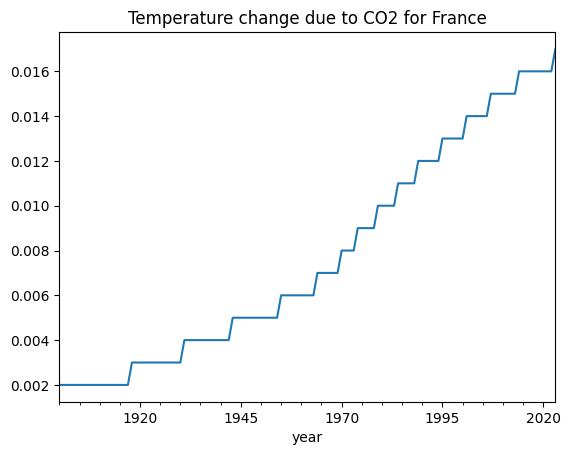

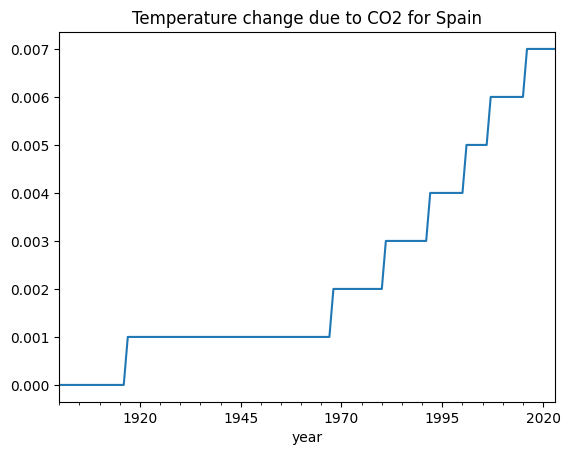

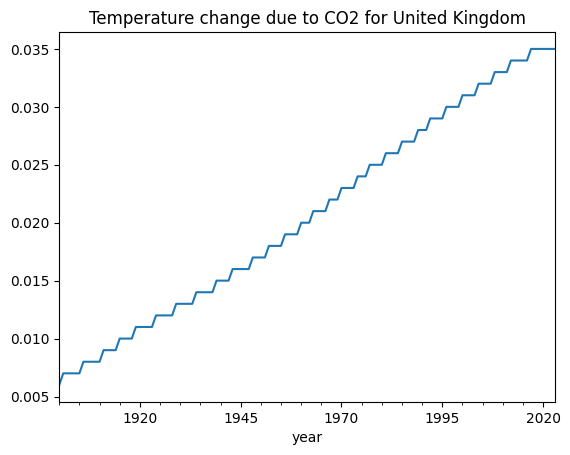

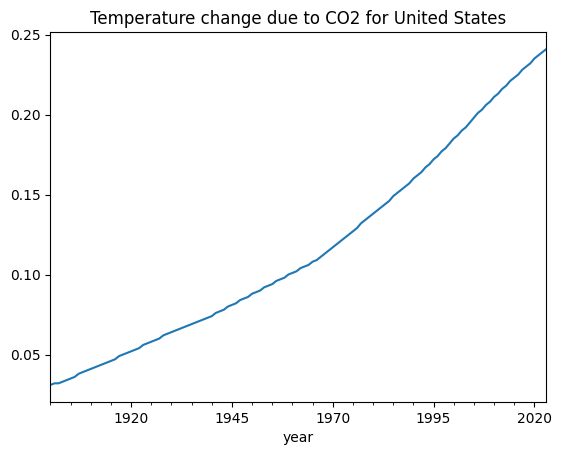

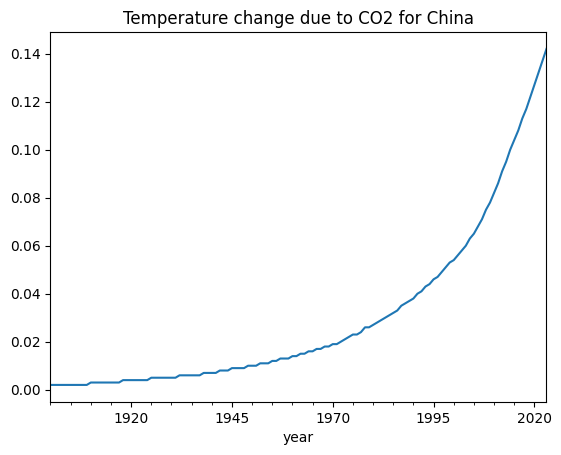

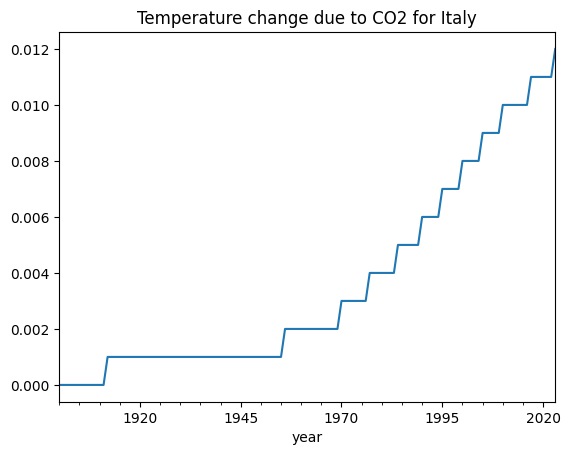

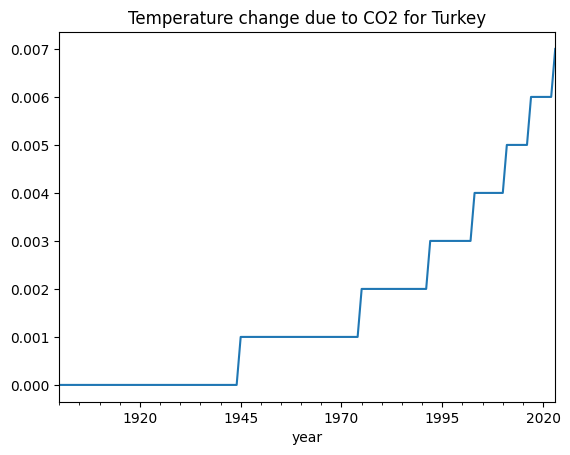

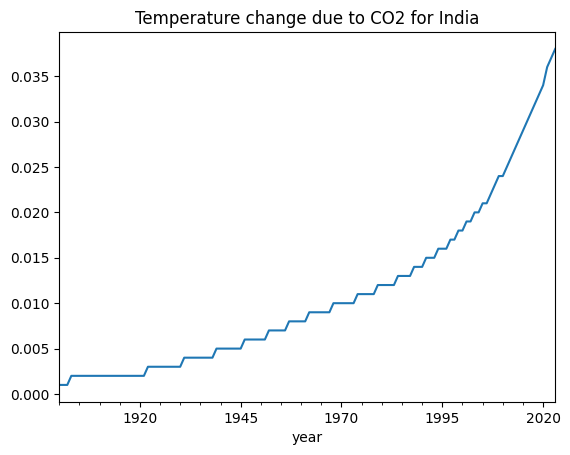

In [35]:
plot_time_series(temperature_grouped, column_to_analyze, selected_countries)

In [36]:
countries_adf_selected = check_adf_scores(temperature_grouped, column_to_analyze, selected_countries)

ADF rejects null-hypothesis for 1-order differentiated time series for France
ADF rejects null-hypothesis for 1-order differentiated time series for Spain
ADF rejects null-hypothesis for 1-order differentiated time series for Turkey


ADF and ACF-PACF Plots for France
ADF Statistic: 2.339551307180527
p-value: 0.9989789603262353


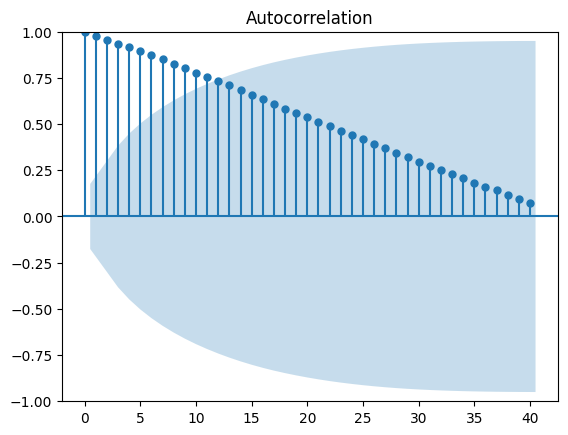

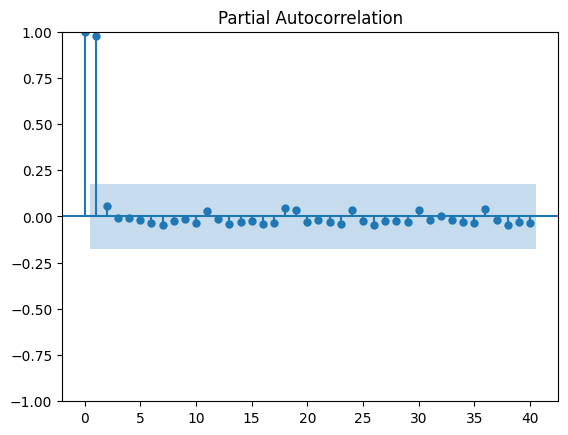







ADF and ACF-PACF Plots for Spain
ADF Statistic: 0.9559575922022515
p-value: 0.9937788132113019


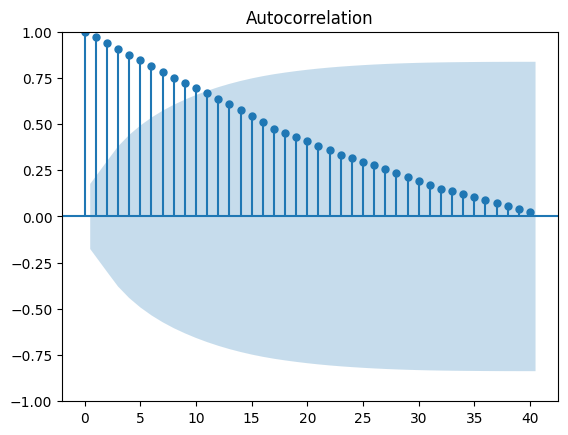

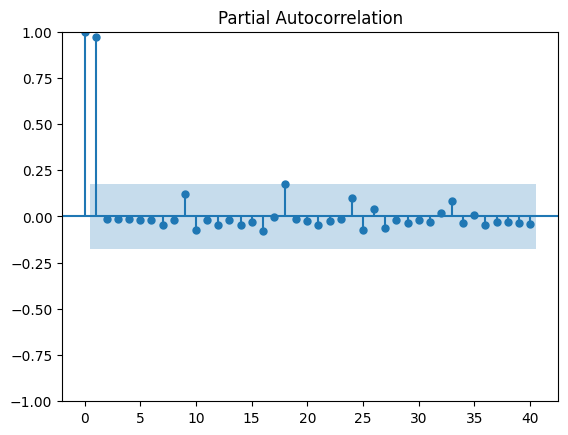







ADF and ACF-PACF Plots for Turkey
ADF Statistic: 3.443112044226831
p-value: 1.0


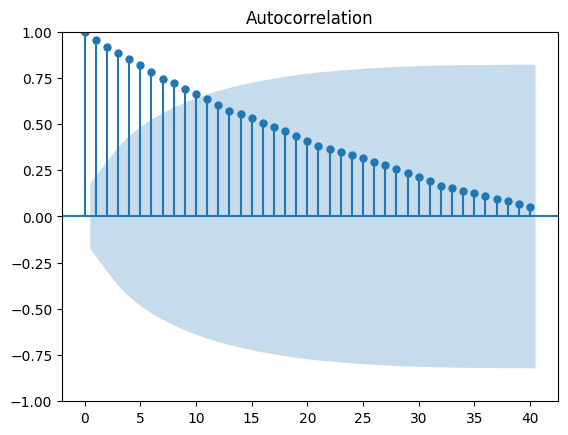

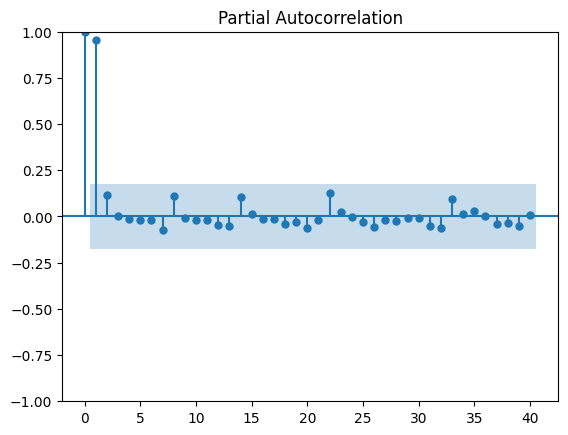

In [37]:
acf_pcaf_plots_no_diff(temperature_grouped, column_to_analyze, countries_adf_selected)

ADF and ACF-PACF Plots for France
ADF Statistic: -7.68397782335382
p-value: 1.4783388393654618e-11


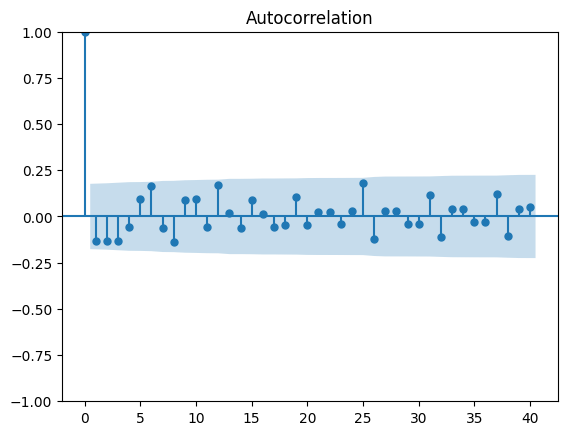

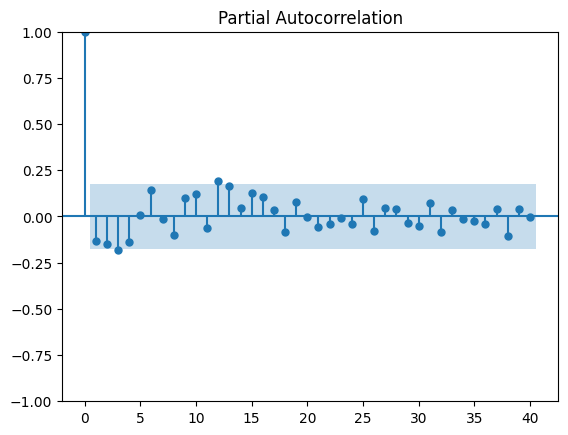







ADF and ACF-PACF Plots for Spain
ADF Statistic: -11.642832797715311
p-value: 2.126581079601321e-21


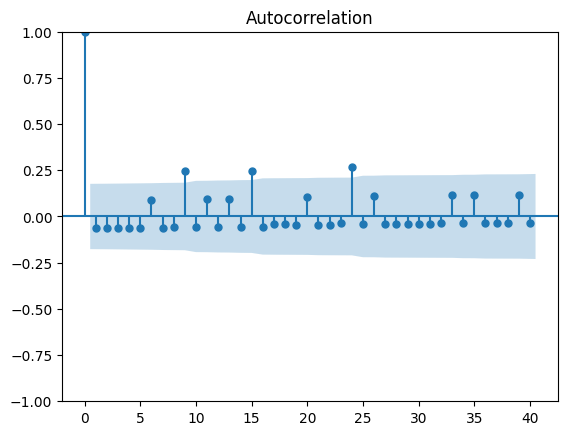

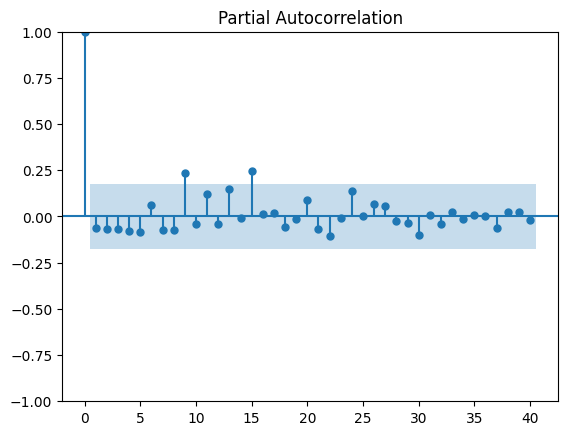







ADF and ACF-PACF Plots for Turkey
ADF Statistic: -10.817556578395815
p-value: 1.8406148840926669e-19


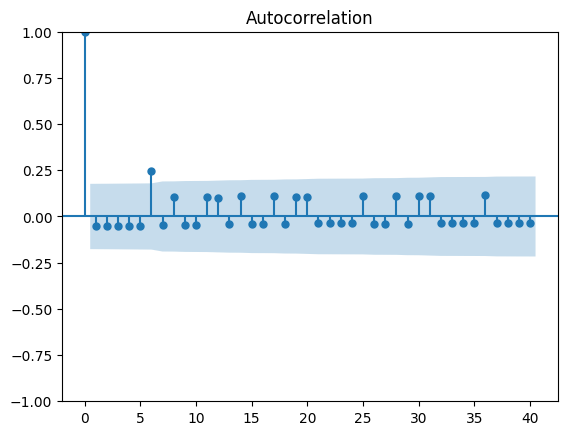

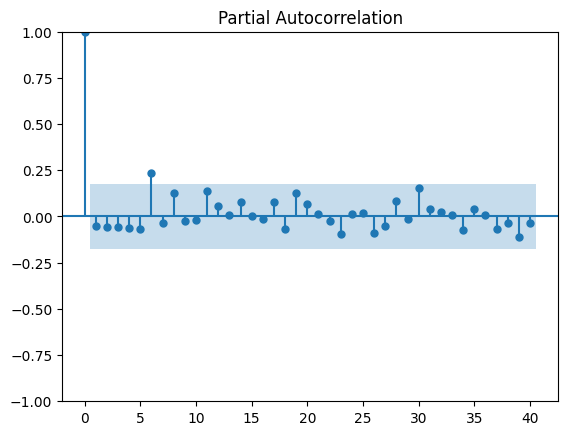

In [38]:
acf_pcaf_plots_n_order_diff(temperature_grouped, column_to_analyze, countries_adf_selected)

## Statistical Models

In [39]:
# CO2
country_model_params = {
    'France': {
        'model1': (11,1,0),
        'model2': (1,1,0),
        'model3': (2,1,0)
    },
    'Spain':{
        'model1': (0,1,15),
        'model2': (0,1,9),
        'model3': (0,1,1)
    },
    'Turkey': {
        'model1': (1,1,5),
        'model2': (1,1,1)
    }
}

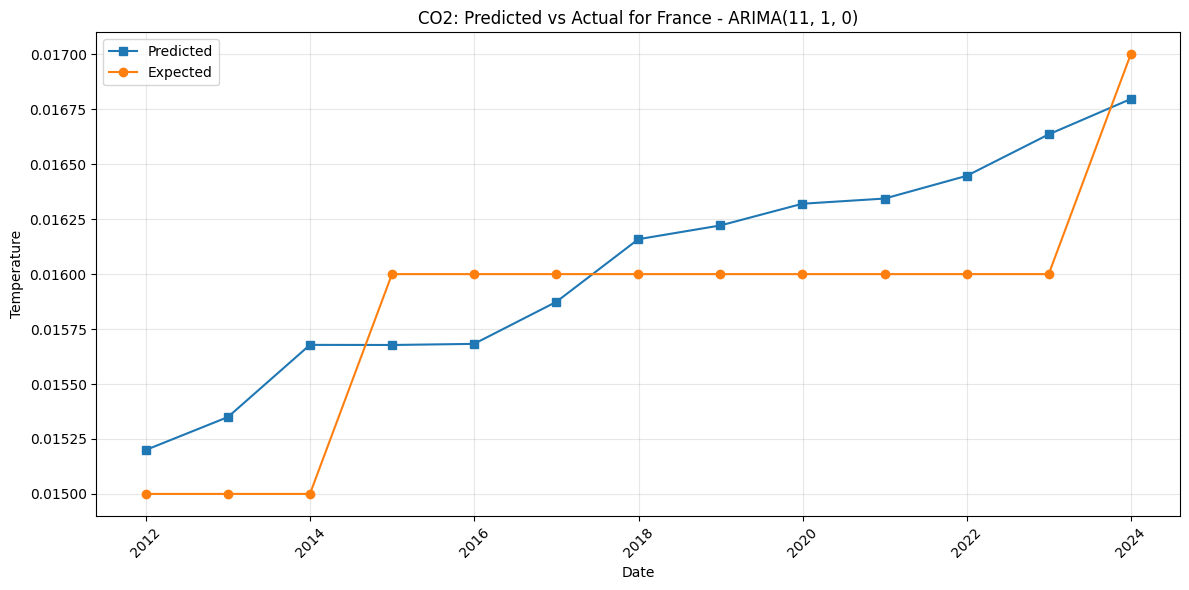

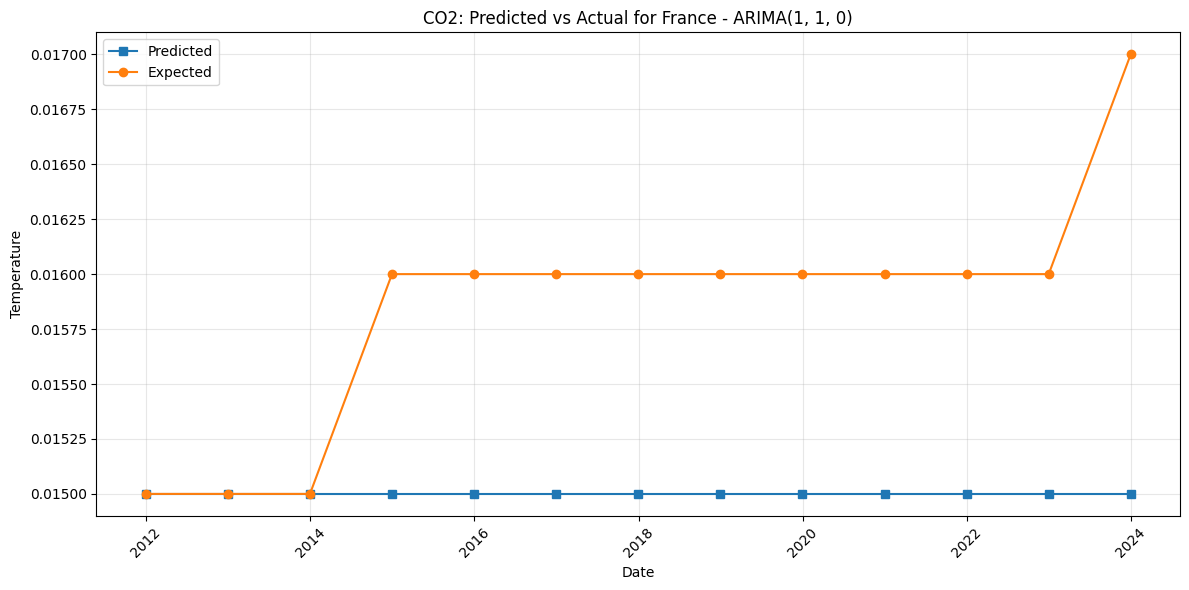

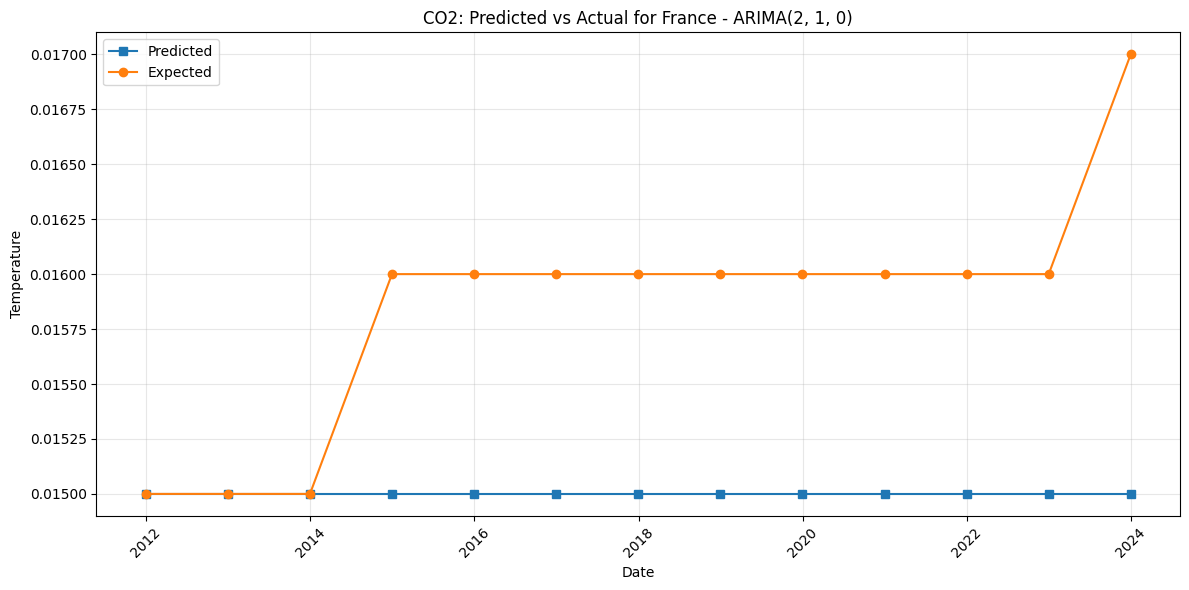

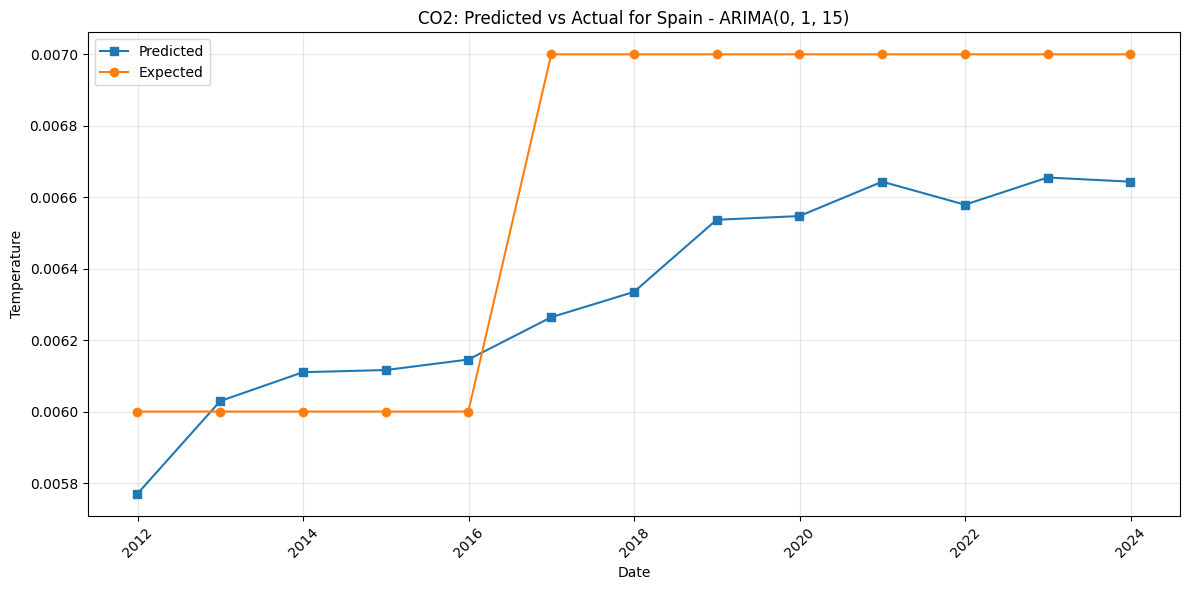

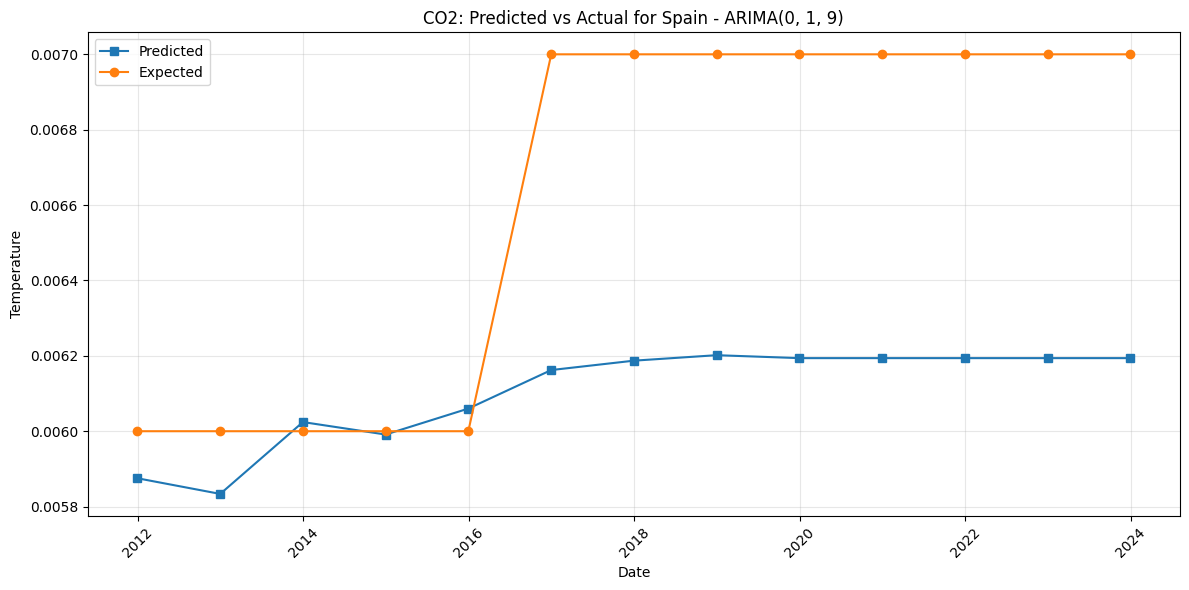

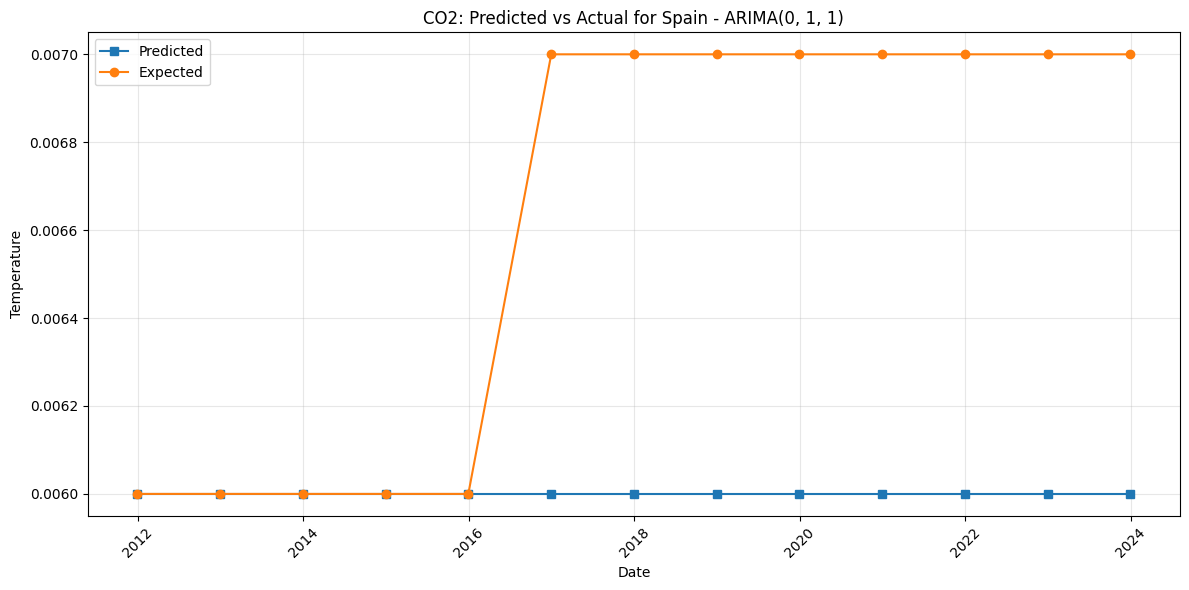

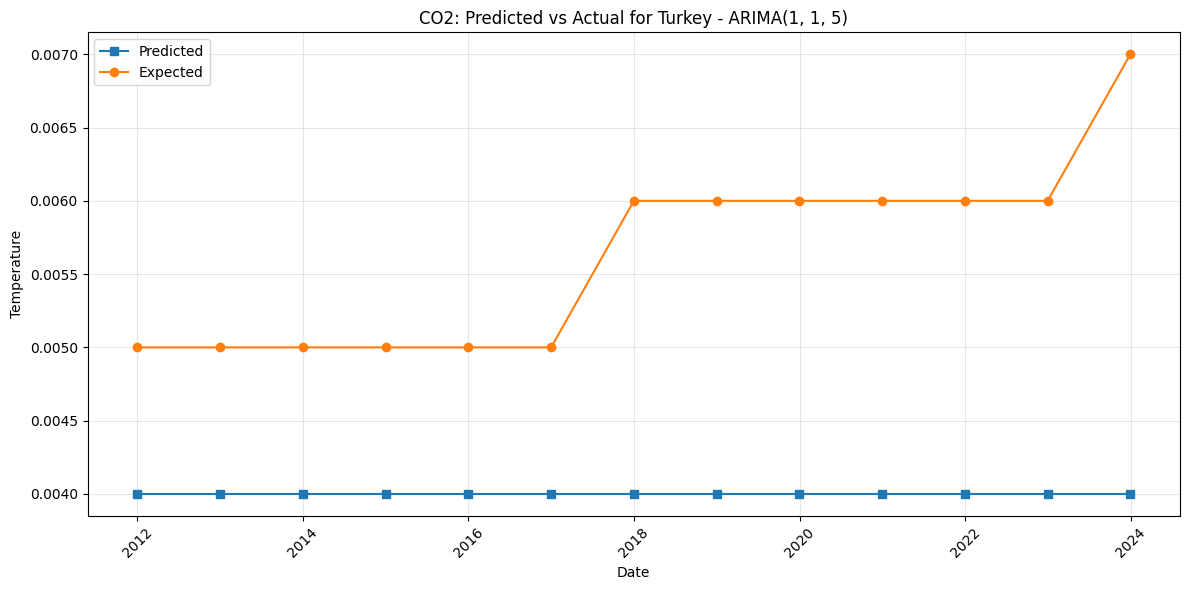

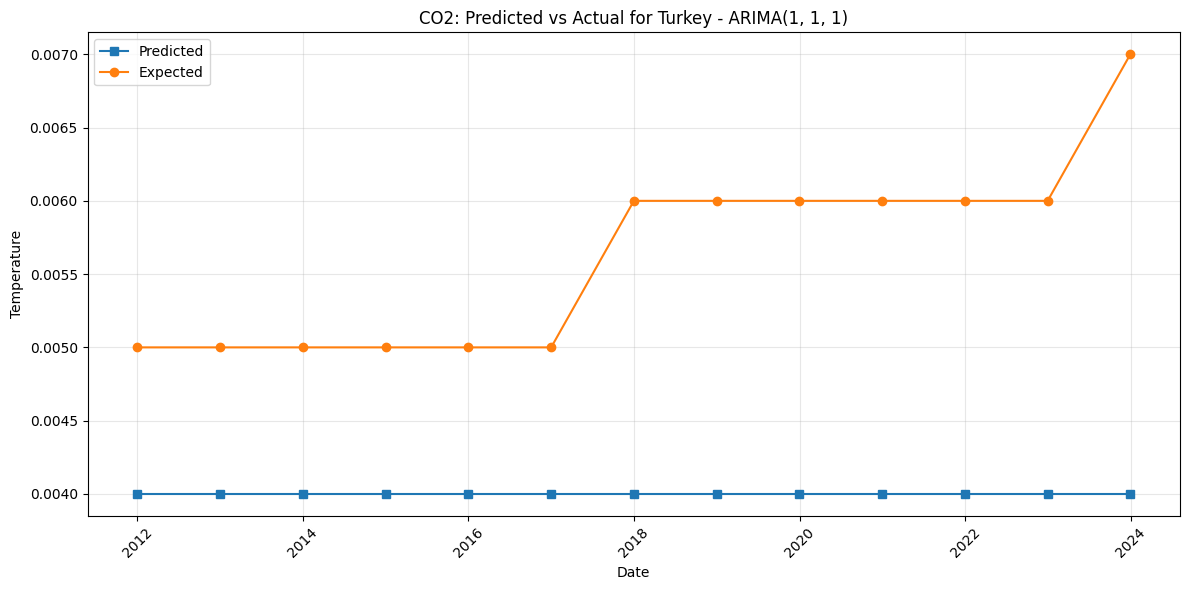

In [41]:
model_details_dict = []

for country, _ in countries_adf_selected:
  dict_ = country_model_params[country]
  for model_name in dict_.keys():
    df_ = temperature_grouped.get_group(country)
    # plot_seasonal_decomposition(df_, 'temperature_change_from_co2', '', 'additive', 10) # title=f'Decomosition for {country}'
    temperature_change = df_[column_to_analyze]
    temperature_change_train = temperature_change[temperature_change.index <= year_split]
    temperature_change_test = temperature_change[temperature_change.index > year_split]
    forecast, model_details = arima_model(temperature_change_train, temperature_change_test, dict_[model_name])

    # Calculate residuals
    residuals = temperature_change_test - forecast
    # Apply Ljung-Box test on the residuals
    ljung_box_result = acorr_ljungbox(residuals, lags=1).lb_pvalue[1] # Test for lag 1 to make it comparable with the statistical models
    # Aply Jarque-Bora test on the residuals
    jb_statistic, jb_pvalue = jarque_bera(residuals)

    model_details.update({
        'mae': mean_absolute_error(temperature_change_test, forecast),
        'mape': mean_absolute_percentage_error(temperature_change_test, forecast),
        'ljung_box_score': float(ljung_box_result),
        'jarque_bera_score': float(jb_pvalue),
        'country': country,
        'model_type': 'statistical',
        'gas_type': gas_type
    })
    model_details_dict.append(model_details)
    arima_model_name = model_details['model_name']
    plot_test_forecast(temperature_change_test, forecast, f'{gas_type}: Predicted vs Actual for {country} - {arima_model_name}')
    print('\n\n')
  print('\n\n\n\n\n')

## Prophet

1. Update the functions to contain custom image titles

2. Update the country_metric_details to include the metrics from all other model outputs

3. Add logic to test the jarqu-bera test on the residuals to check if the residuals follow a normal distribution

from scipy.stats import jarque_bera

jb_statistic, p_value = jarque_bera(residuals)

  0%|          | 0/8 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/v5du0j5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/6y27vosm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10385', 'data', 'file=/tmp/tmpnmxmjag4/v5du0j5d.json', 'init=/tmp/tmpnmxmjag4/6y27vosm.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelwrlinhw8/prophet_model-20250805220601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

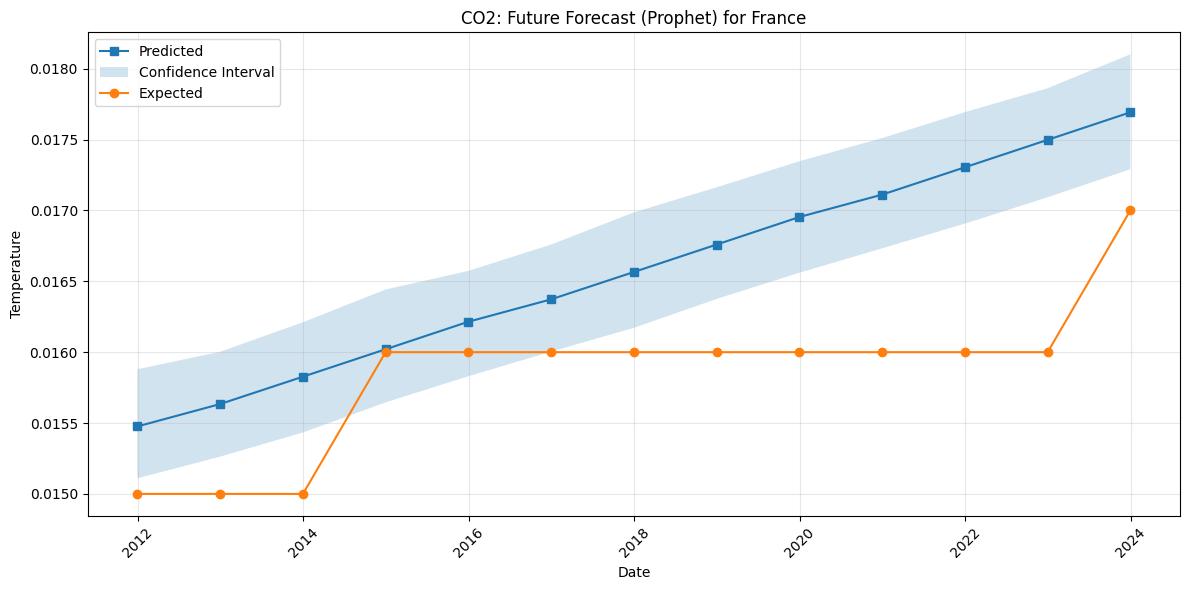

<Figure size 1000x500 with 0 Axes>

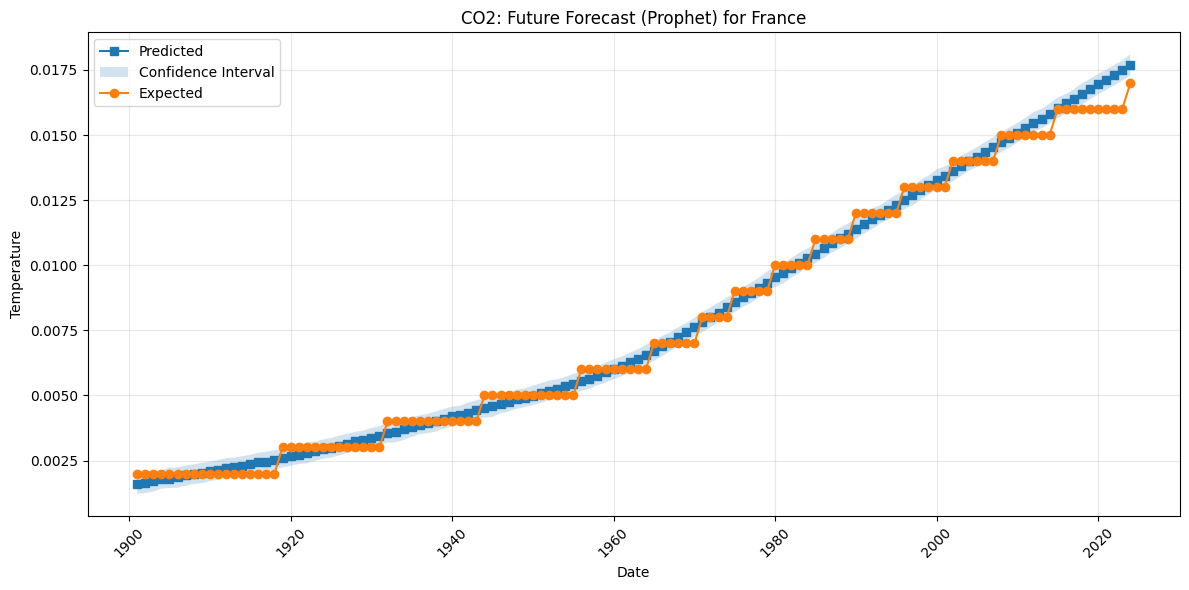

 12%|█▎        | 1/8 [00:00<00:04,  1.71it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/63c5bhbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/2v1sf0ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95703', 'data', 'file=/tmp/tmpnmxmjag4/63c5bhbp.json', 'init=/tmp/tmpnmxmjag4/2v1sf0ds.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelqemnvtos/prophet_model-20250805220601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

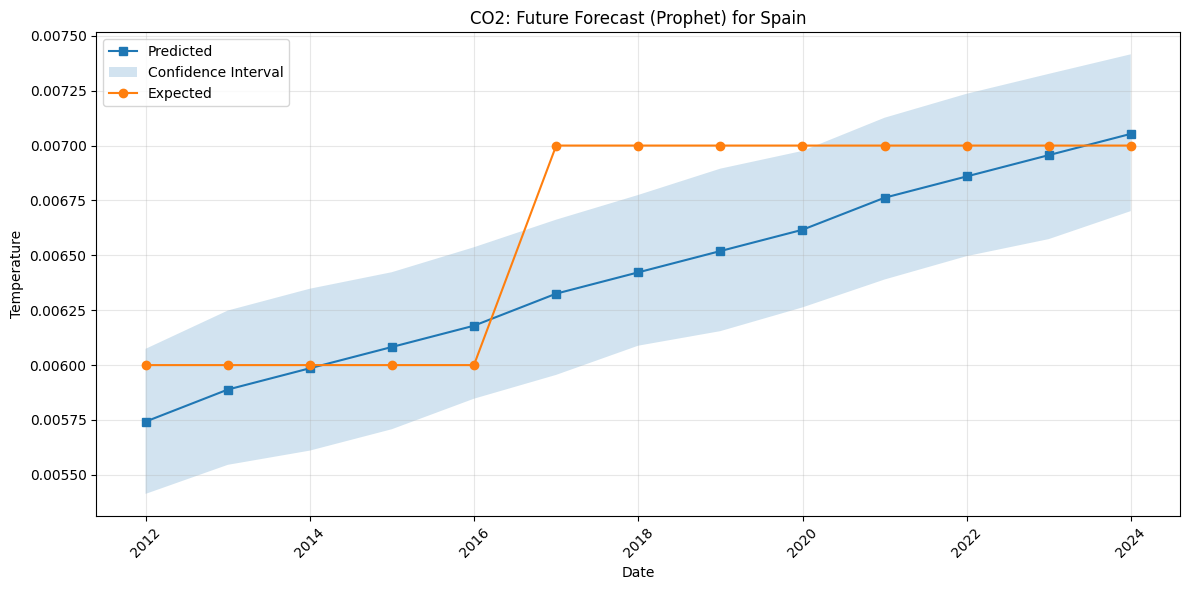

<Figure size 1000x500 with 0 Axes>

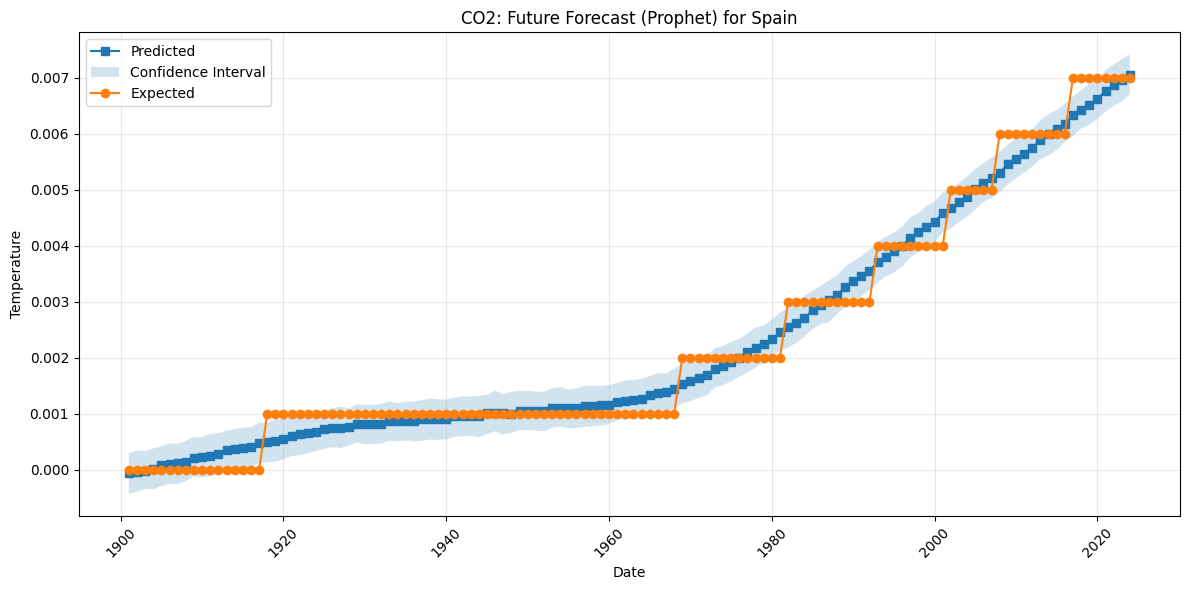

 25%|██▌       | 2/8 [00:01<00:03,  1.68it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/mb5lvh_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/72bektku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25226', 'data', 'file=/tmp/tmpnmxmjag4/mb5lvh_s.json', 'init=/tmp/tmpnmxmjag4/72bektku.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelris0olji/prophet_model-20250805220602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

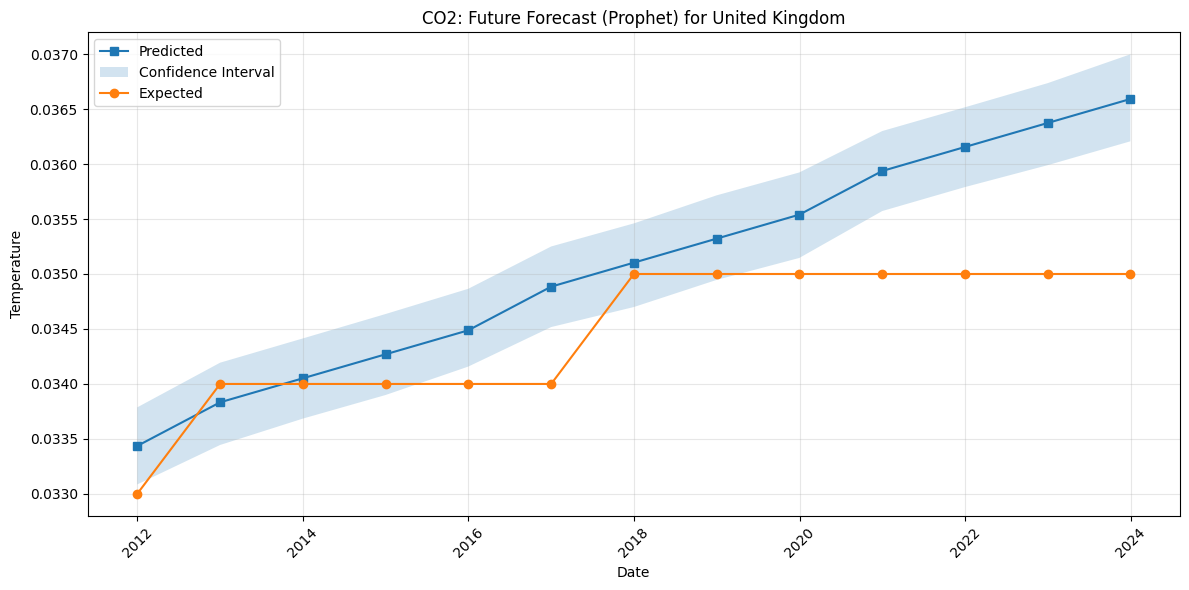

<Figure size 1000x500 with 0 Axes>

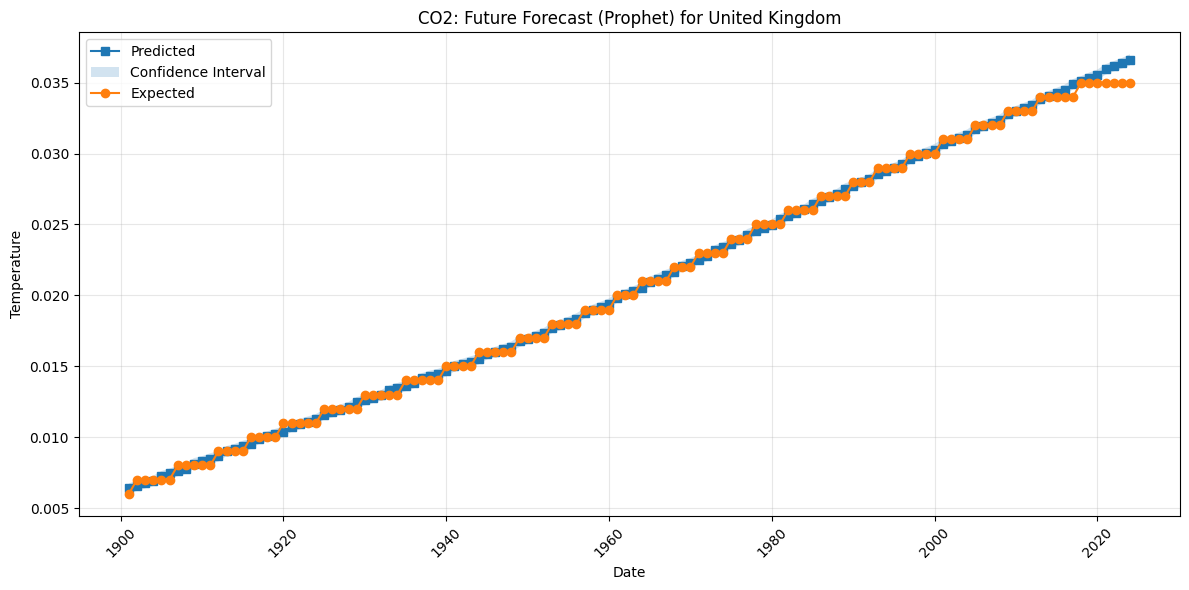

 38%|███▊      | 3/8 [00:01<00:02,  1.69it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/0hsglrfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/yq_xcx9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33238', 'data', 'file=/tmp/tmpnmxmjag4/0hsglrfr.json', 'init=/tmp/tmpnmxmjag4/yq_xcx9t.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_model86gae2r9/prophet_model-20250805220603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

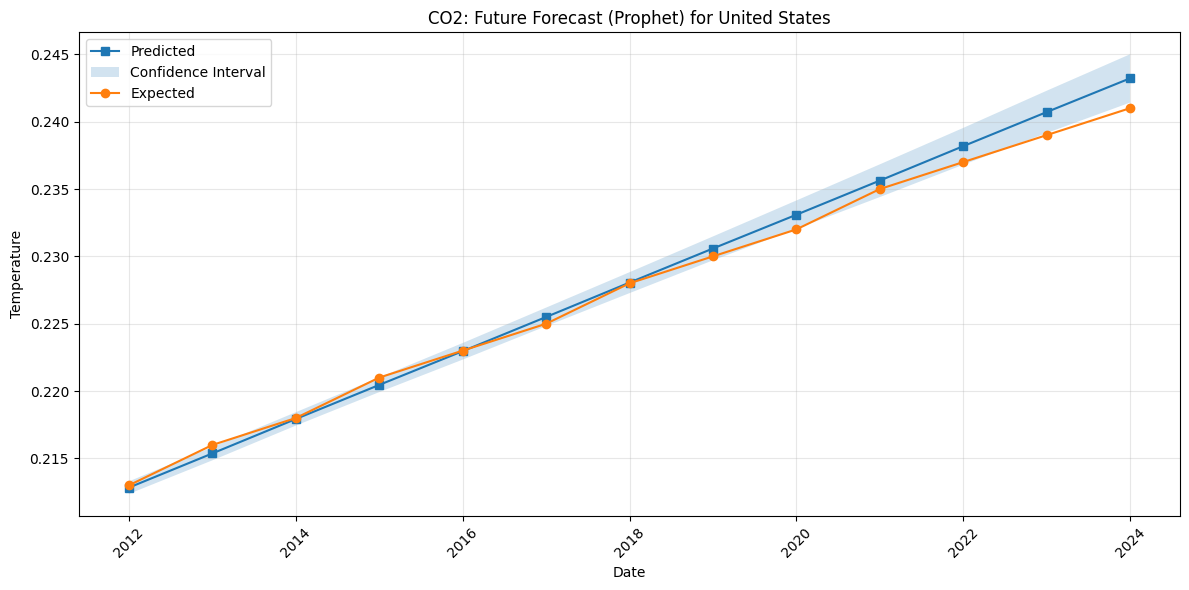

<Figure size 1000x500 with 0 Axes>

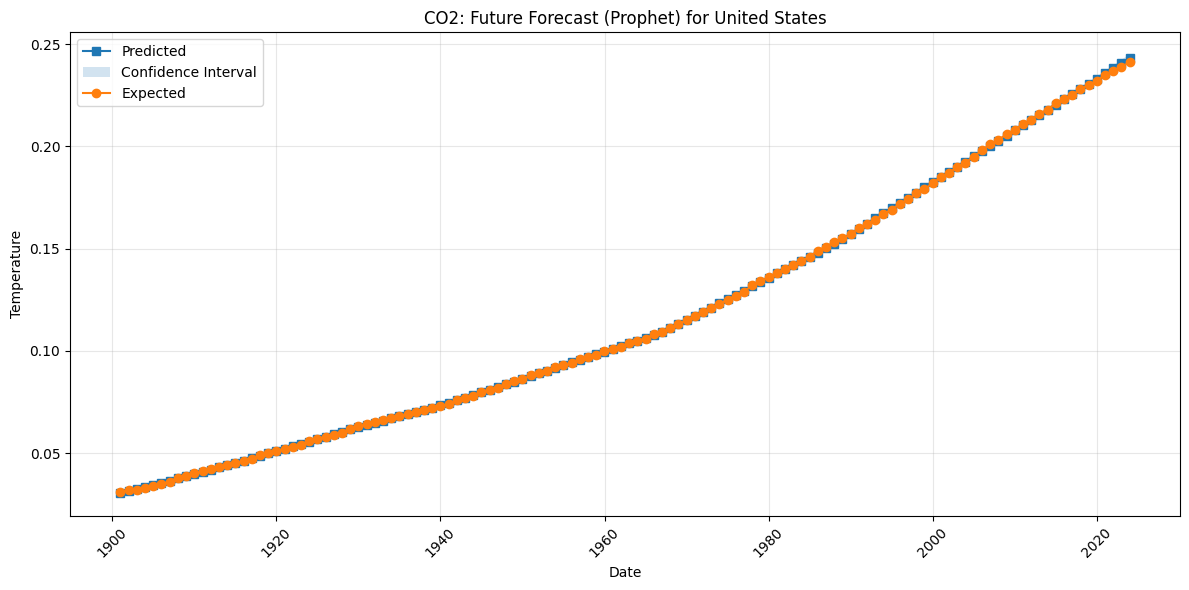

 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/fhfm13_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/a4hkt199.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98383', 'data', 'file=/tmp/tmpnmxmjag4/fhfm13_w.json', 'init=/tmp/tmpnmxmjag4/a4hkt199.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_model3evfr7z2/prophet_model-20250805220603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

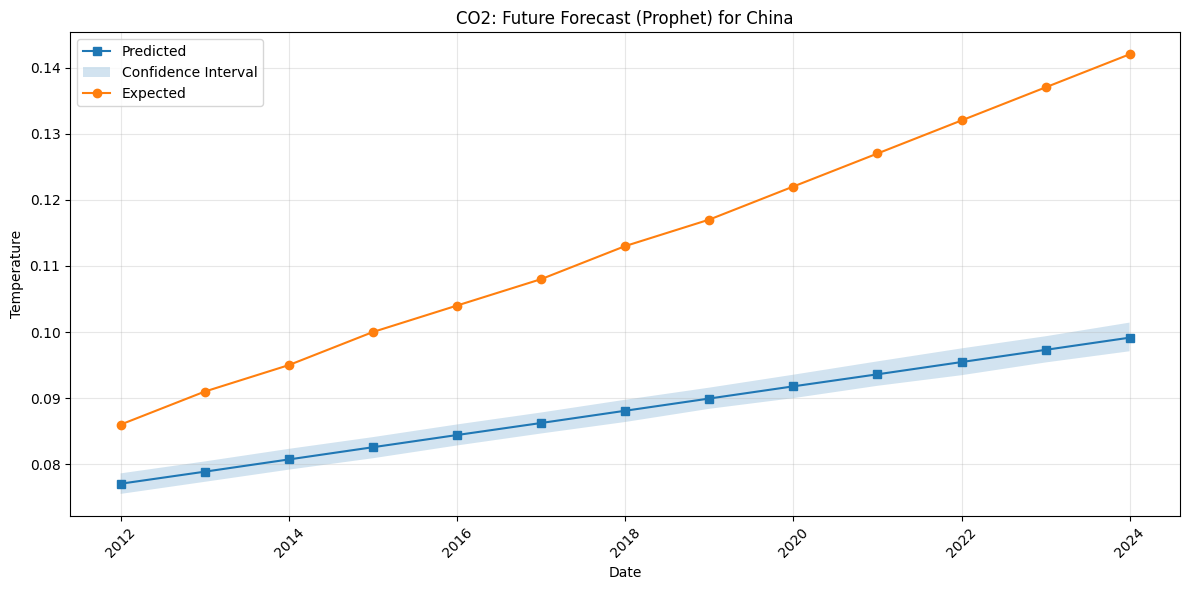

<Figure size 1000x500 with 0 Axes>

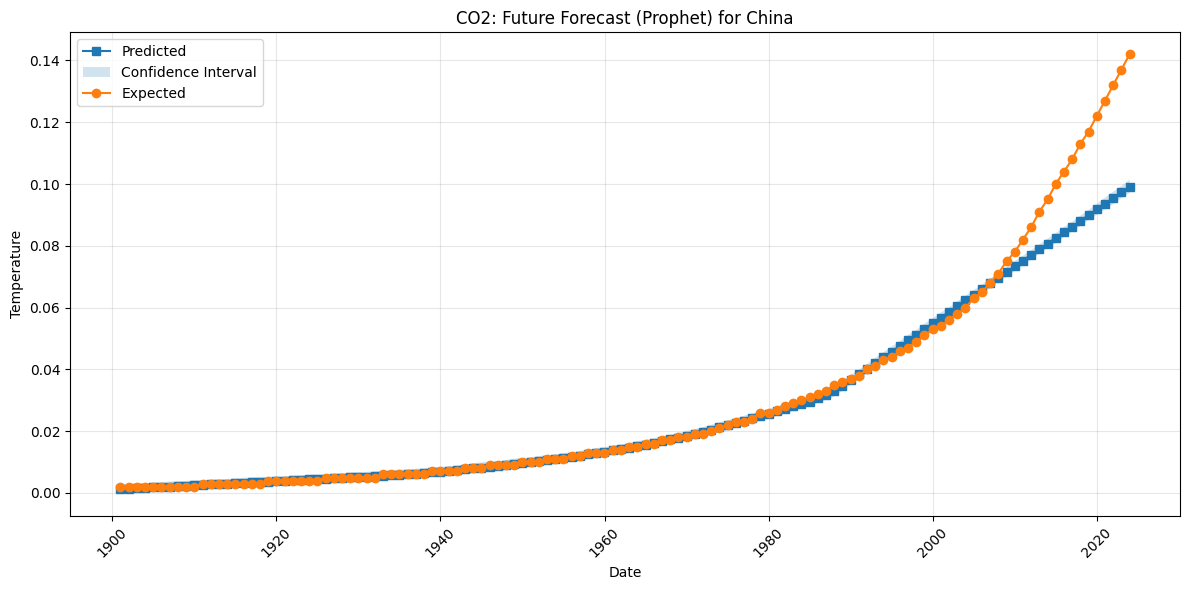

 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/9an24o3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/fyrpxr74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94378', 'data', 'file=/tmp/tmpnmxmjag4/9an24o3t.json', 'init=/tmp/tmpnmxmjag4/fyrpxr74.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelg0azgdwb/prophet_model-20250805220604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

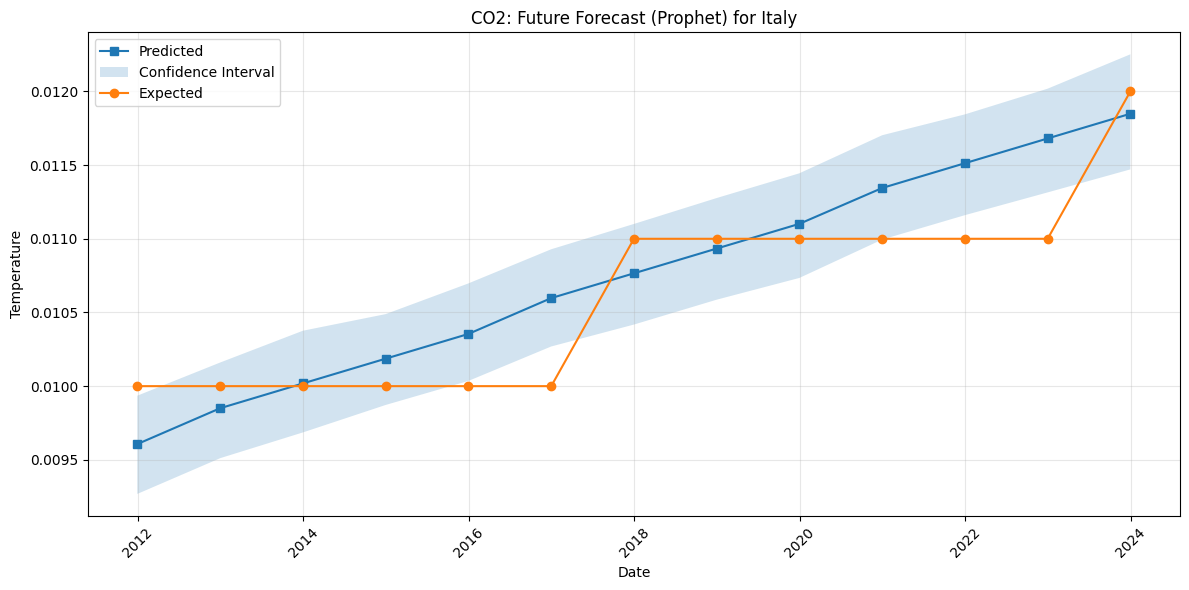

<Figure size 1000x500 with 0 Axes>

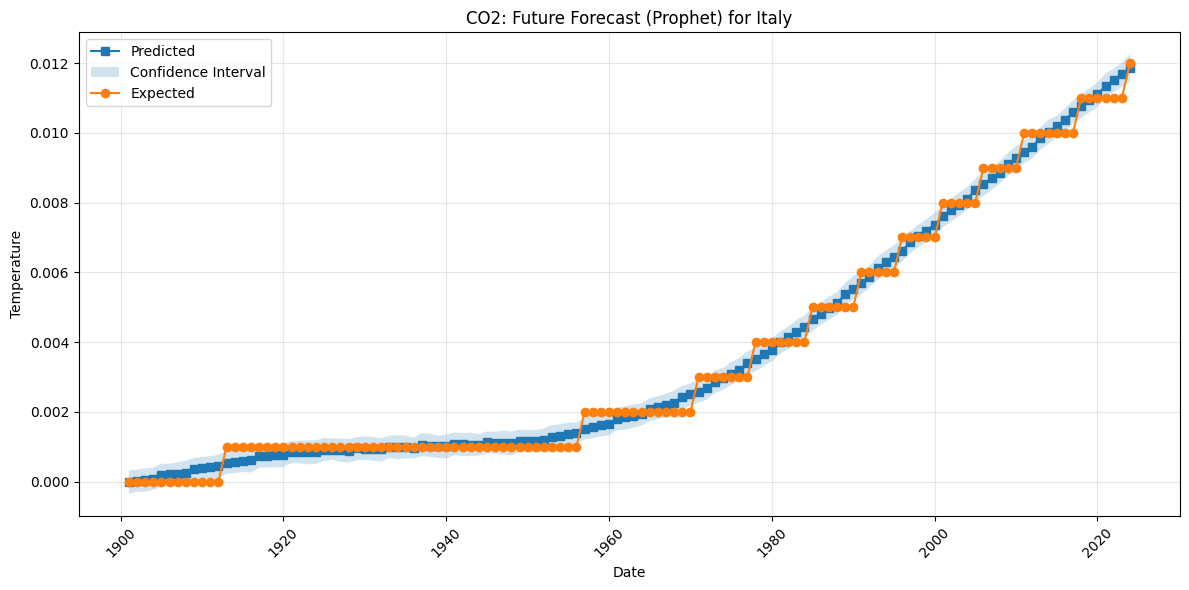

 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/5947njfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/igczsjm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79624', 'data', 'file=/tmp/tmpnmxmjag4/5947njfn.json', 'init=/tmp/tmpnmxmjag4/igczsjm2.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelcea9rusn/prophet_model-20250805220605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

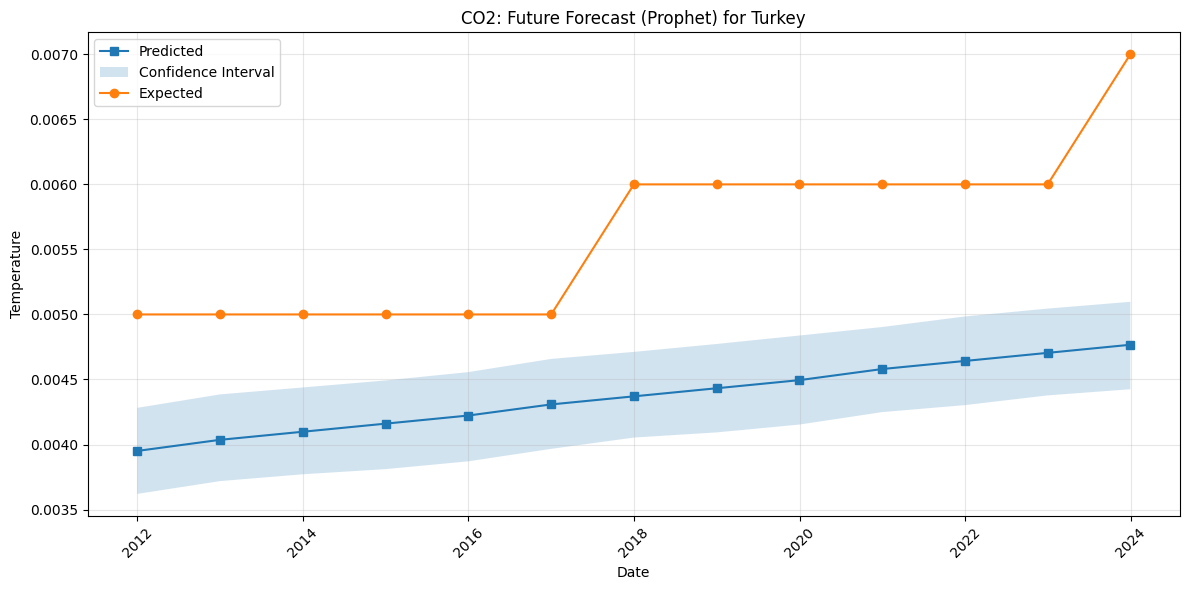

<Figure size 1000x500 with 0 Axes>

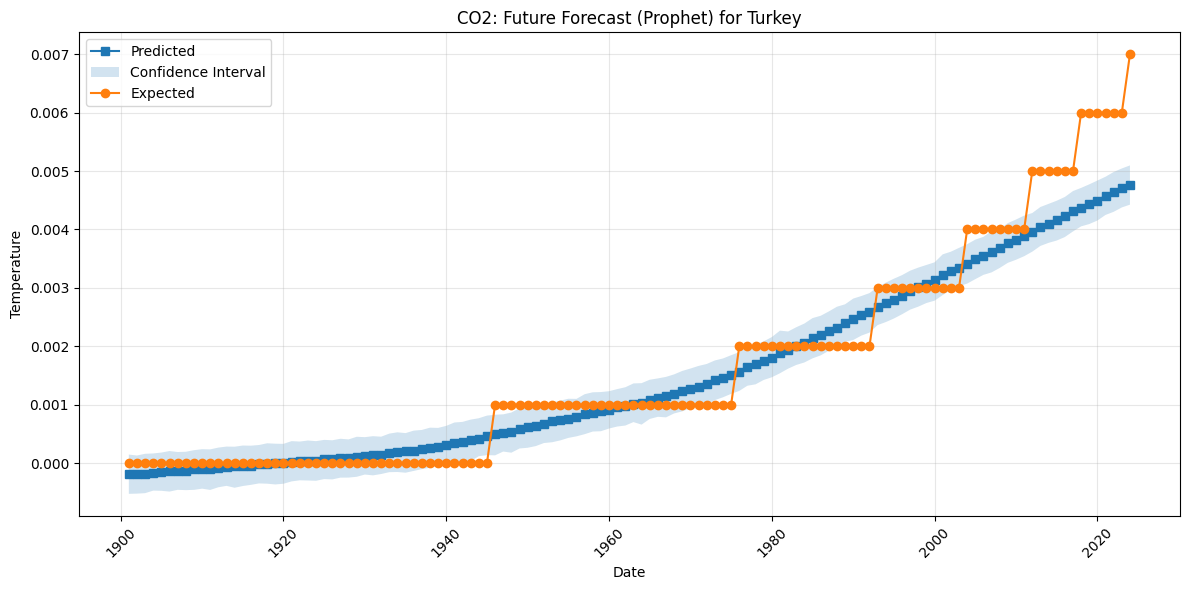

 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/agjmgog2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmxmjag4/skl0viip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56086', 'data', 'file=/tmp/tmpnmxmjag4/agjmgog2.json', 'init=/tmp/tmpnmxmjag4/skl0viip.json', 'output', 'file=/tmp/tmpnmxmjag4/prophet_modelh3oxg05o/prophet_model-20250805220605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

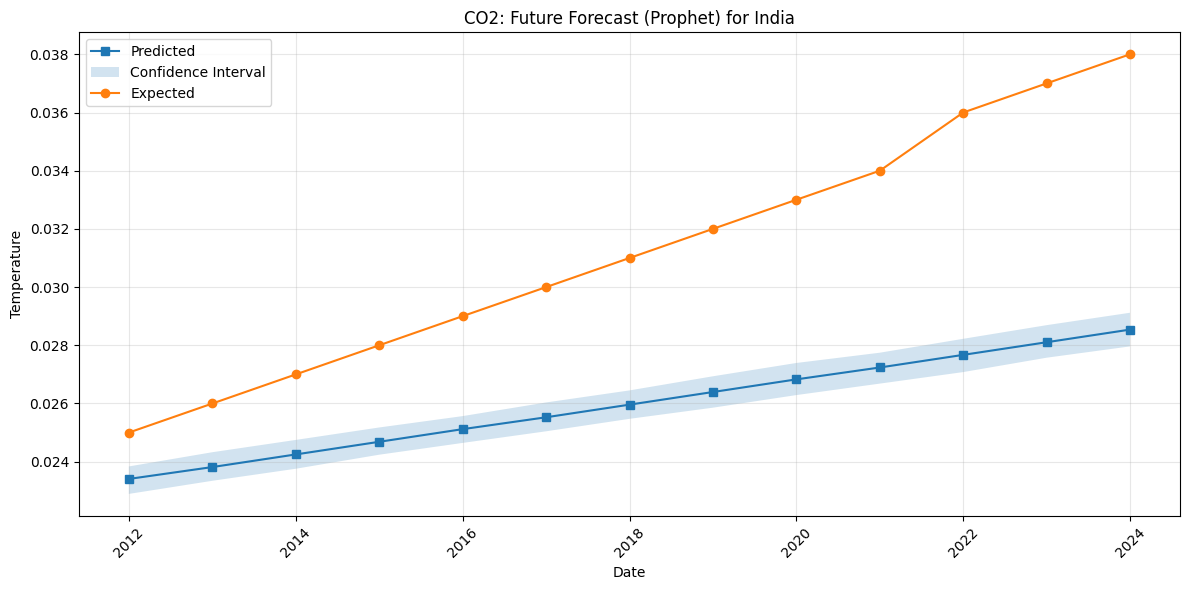

<Figure size 1000x500 with 0 Axes>

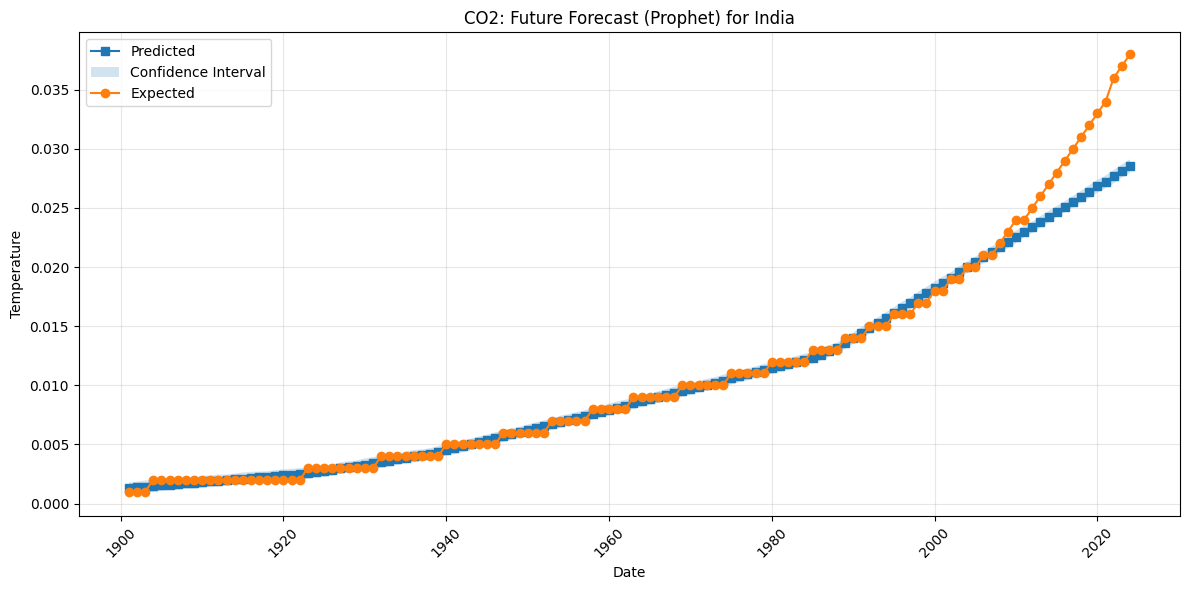

100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

In [43]:
for country in tqdm(selected_countries):
  df_prophet = format_data_for_prophet(temperature_grouped.get_group(country).reset_index()[['year', column_to_analyze]])
  df_prophet_train = df_prophet[df_prophet['ds'] <= year_split]
  df_prophet_test = df_prophet[df_prophet['ds'] > year_split]
  forecast_prophet = train_and_forecast_prophet(df_prophet_train, df_prophet_test) # Contains the forecasted values starting from 1900
  # Filter for values only after the traning period
  test_predictions = forecast_prophet[(forecast_prophet['ds'] > year_split) & (forecast_prophet['ds'] <= last_date)]

  # Plot the graphs
  plot_actual_forecast_prophet(df_prophet_test, test_predictions, country, gas_type)
  plot_actual_forecast_prophet(df_prophet, forecast_prophet[forecast_prophet['ds'] <= last_date], country, gas_type)
  print('\n\n\n')

  # Calculate the errors
  mae = round(mean_absolute_error(df_prophet_test['y'].values, test_predictions['yhat'].values), 6)
  mape = round(mean_absolute_percentage_error(df_prophet_test['y'].values, test_predictions['yhat'].values), 6)

  # Calculate residuals
  residuals = df_prophet['y'] - forecast_prophet[forecast_prophet['ds'] <= last_date]['yhat']
  # Apply Ljung-Box test on the residuals
  ljung_box_result = acorr_ljungbox(residuals, lags=1).lb_pvalue[1] # Test for lag 1 to make it comparable with the statistical models
  # Aply Jarque-Bora test on the residuals
  jb_statistic, jb_pvalue = jarque_bera(residuals)

  # Create a dict for model metrics
  model_metrics = {
      'mae': mae,
      'mape': mape,
      'ljung_box_score': float(ljung_box_result),
      'jarque_bera_score': float(jb_pvalue),
      'country': country,
      'model_type': 'prophet',
      'gas_type': gas_type
  }
  # Append to the final model details
  model_details_dict.append(model_metrics)

## ML - Random Forest

In [ ]:
for country in tqdm(selected_countries):
  # load the dataset
  values = temperature_grouped.get_group(country)[[column_to_analyze]].values # temperature_change_from_co2, temperature_change_from_ch4
  # transform the time series data into supervised learning
  data = series_to_supervised(values, n_in=6)
  # evaluate
  test_actual, test_predicted = walk_forward_validation(data, 13)

  # Plot the graphs
  plot_test_forecast_randomforest(test_actual, test_predicted, temperature_grouped.get_group(country).index[-13:], country, gas_type)
  print('\n\n\n')

  # Calculate the errors
  mae = round(mean_absolute_error(test_actual, test_predicted), 6)
  mape = round(mean_absolute_percentage_error(test_actual, test_predicted), 6)

  # Calculate residuals
  residuals = test_actual - test_predicted
  # Apply Ljung-Box test on the residuals
  ljung_box_result = acorr_ljungbox(residuals, lags=1).lb_pvalue[1] # Test for lag 1 to make it comparable with the statistical models
  # Aply Jarque-Bora test on the residuals
  jb_statistic, jb_pvalue = stats.jarque_bera(residuals)

  # Create a dict for model metrics
  model_metrics = {
      'mae': mae,
      'mape': mape,
      'ljung_box_score': float(ljung_box_result),
      'jarque_bera_score': float(jb_pvalue),
      'country': country,
      'model_type': 'randomforest',
      'gas_type': gas_type
  }
  # Append to the final model details
  model_details_dict.append(model_metrics)

## DL - LSTM

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


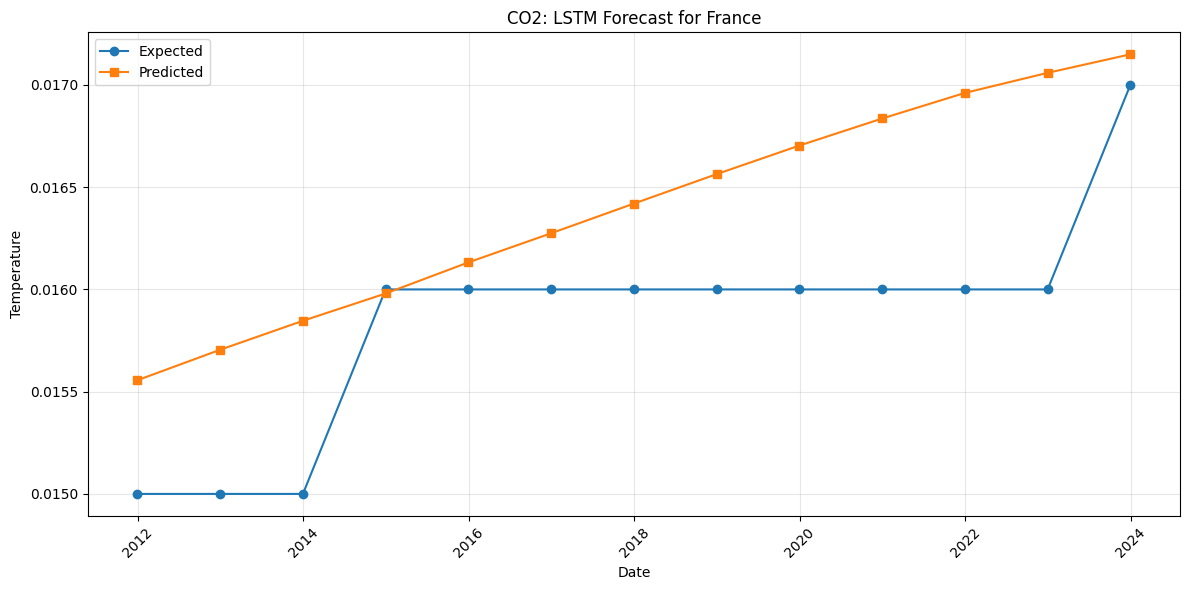

 12%|█▎        | 1/8 [00:19<02:15, 19.33s/it]






1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


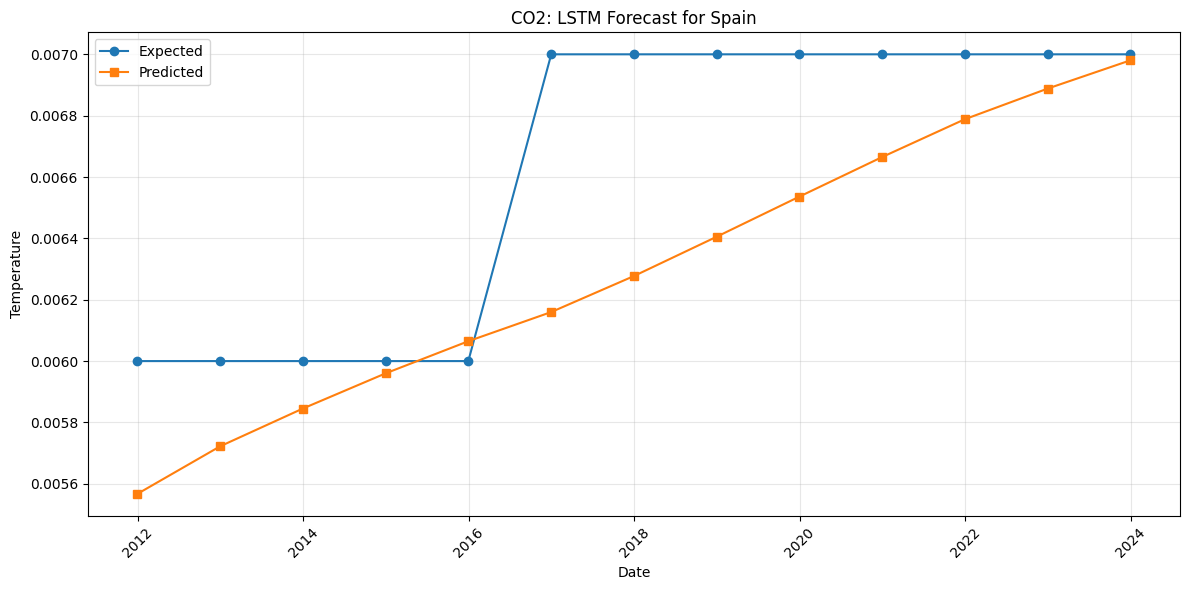

 25%|██▌       | 2/8 [00:36<01:47, 17.96s/it]






1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


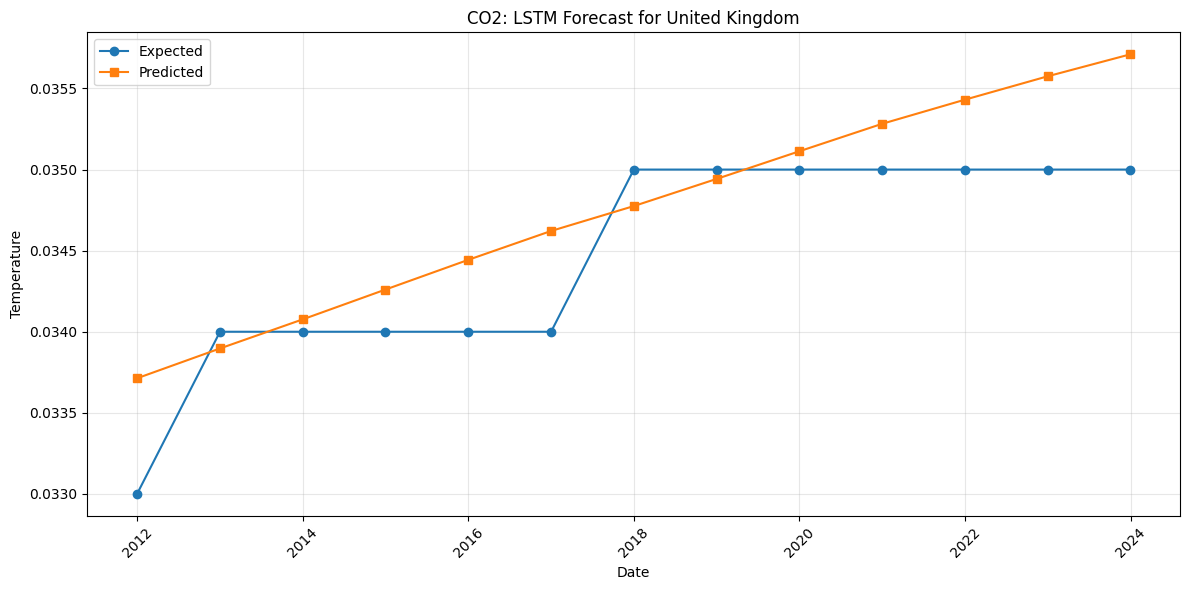

 38%|███▊      | 3/8 [00:52<01:26, 17.31s/it]






1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


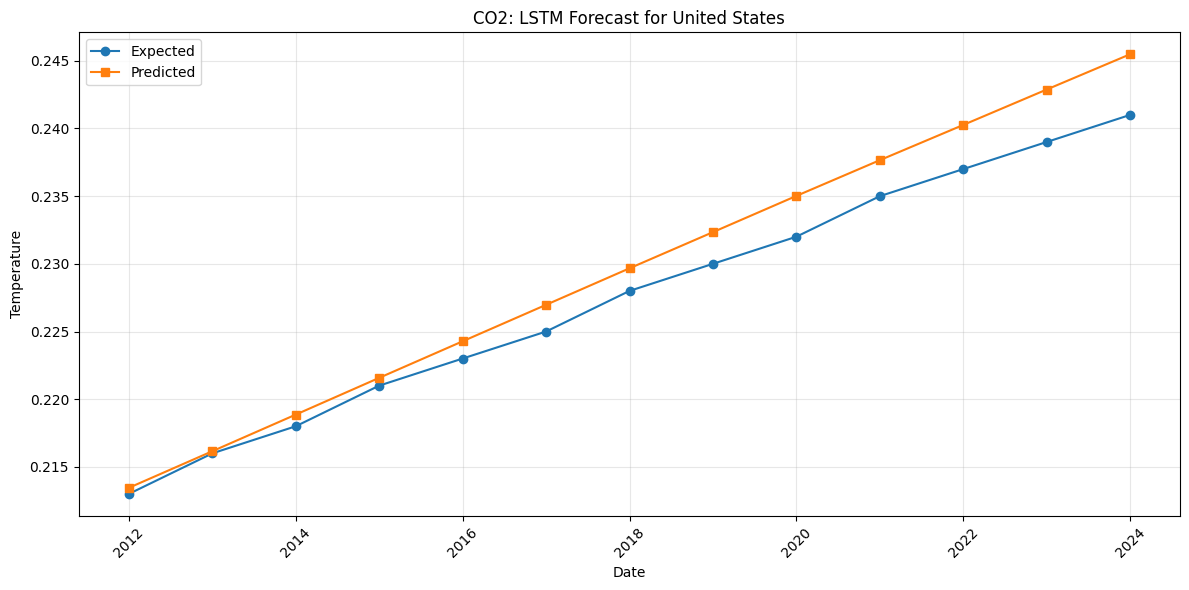

 50%|█████     | 4/8 [01:09<01:08, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


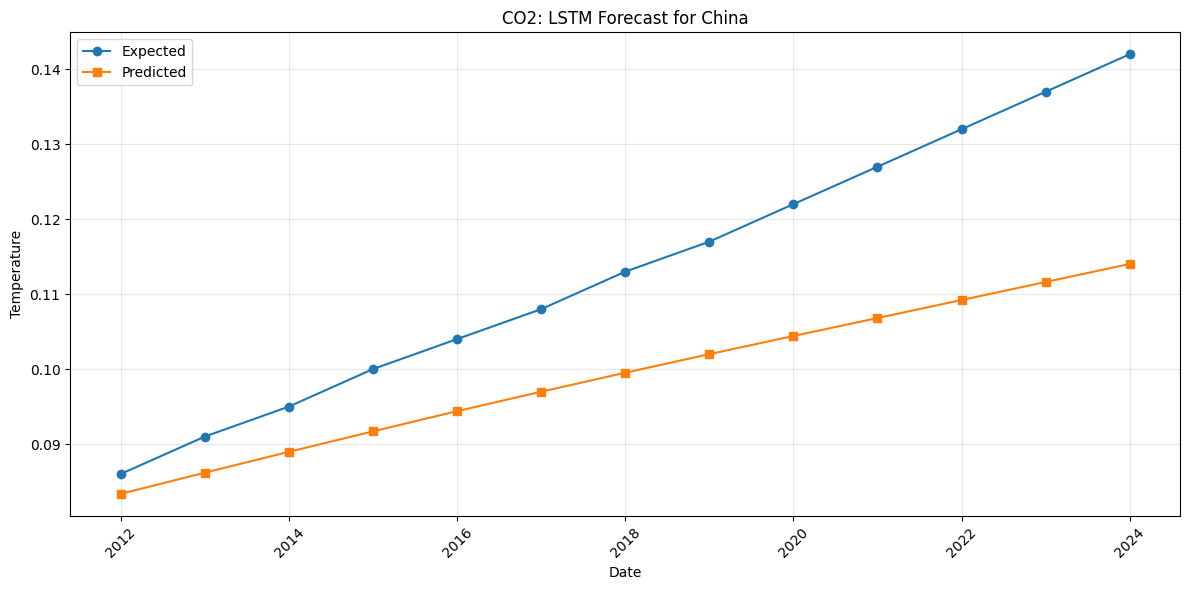

 62%|██████▎   | 5/8 [01:26<00:50, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


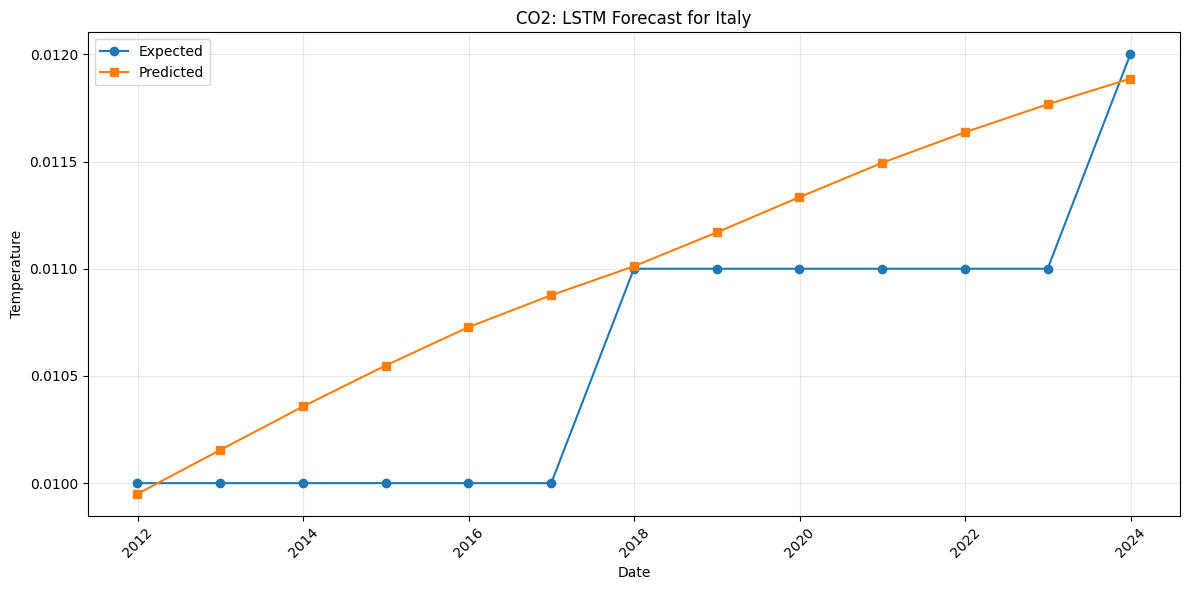

 75%|███████▌  | 6/8 [01:43<00:33, 16.92s/it]






1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


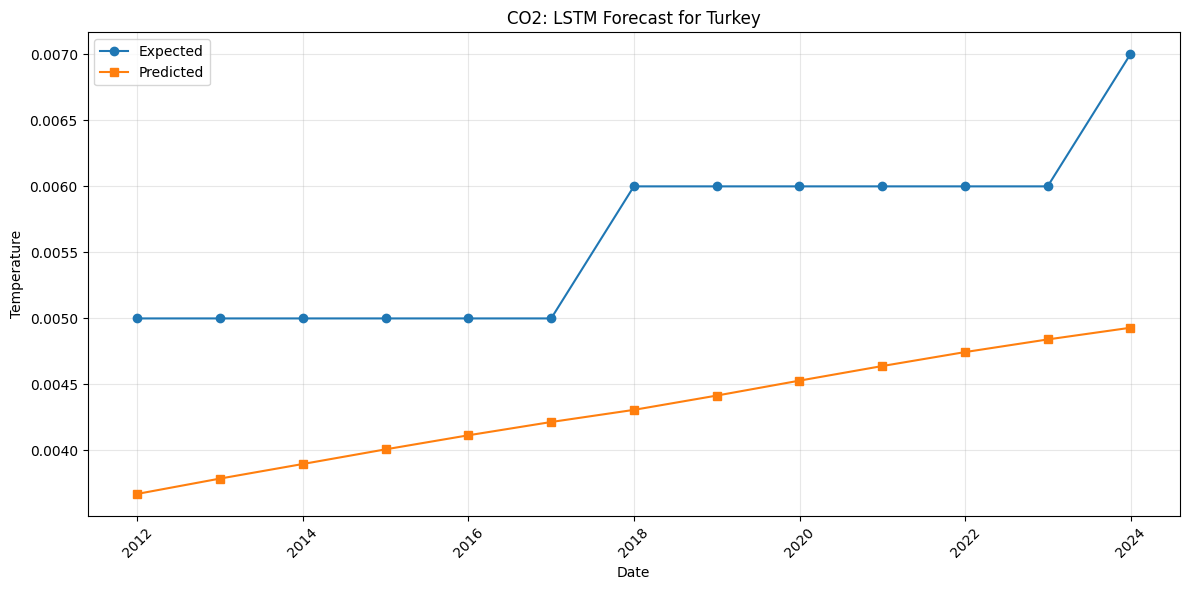

 88%|████████▊ | 7/8 [01:59<00:16, 16.73s/it]






1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


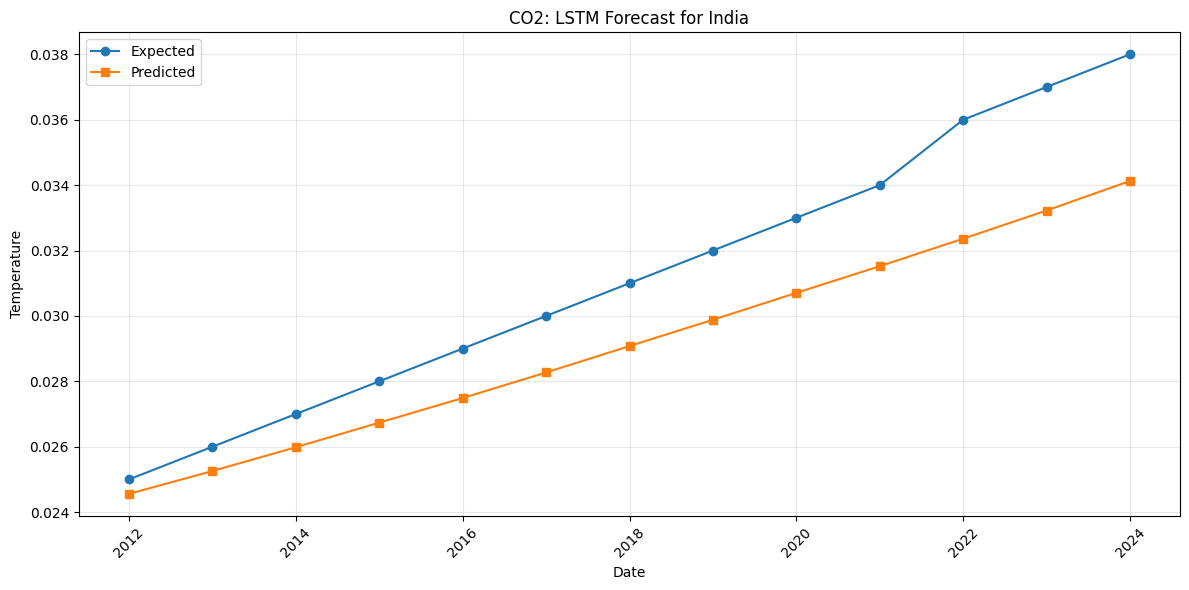

100%|██████████| 8/8 [02:15<00:00, 16.99s/it]

In [44]:
n_steps = 20
test_size = 13

for country in tqdm(selected_countries):
    # Get data for the country
    country_data = temperature_grouped.get_group(country)[column_to_analyze].values

    # Split data
    X_train, X_test, y_train, y_test = split_train_test_lstm(country_data, n_steps, test_size)

    # Train model
    model = train_and_forecast_lstm(X_train, y_train, n_steps)

    # Get predictions and flatten them
    test_predict = model.predict(X_test)
    test_predict = test_predict.flatten()  # FIXED: Flatten predictions

    # Get corresponding dates for plotting
    country_dates = temperature_grouped.get_group(country).index
    test_dates = country_dates[-(test_size):]  # FIXED: Get correct date range

    # Plot the graphs
    plot_test_forecast_lstm(y_test, test_predict, test_dates, country, gas_type)
    print('\n\n\n\n')

    # Calculate the errors - FIXED: Use consistent variable name
    mae = round(mean_absolute_error(y_test, test_predict), 6)
    mape = round(mean_absolute_percentage_error(y_test, test_predict), 6)

    # Calculate residuals
    residuals = y_test - test_predict

    # Apply Ljung-Box test on the residuals
    ljung_box_result = acorr_ljungbox(residuals, lags=1).lb_pvalue[1]

    # Apply Jarque-Bera test on the residuals
    jb_statistic, jb_pvalue = jarque_bera(residuals)

    # Create a dict for model metrics
    model_metrics = {
        'mae': mae,
        'mape': mape,
        'ljung_box_score': float(ljung_box_result),
        'jarque_bera_score': float(jb_pvalue),
        'country': country,
        'model_type': 'LSTM',
        'gas_type': gas_type
    }
    # Append to the final model details
    model_details_dict.append(model_metrics)

# Store model metrics

In [45]:
statistical_model_results = pd.DataFrame(model_details_dict)
statistical_model_results = statistical_model_results[["gas_type", "country", "model_type", "model_name", "mae", "mape", "ljung_box_score", "jarque_bera_score", "aic", "bic"]]

In [46]:
statistical_model_results.to_excel("co2_model_results.xlsx")

# Select the best models

In [47]:
grouped_country_model_results = statistical_model_results.groupby(['country'])
selected_models = pd.DataFrame()

for country in selected_countries:
  metrics_df = grouped_country_model_results.get_group(country)
  metrics_df.reset_index(inplace=True)
  best_models = choose_best_model(metrics_df, 'mae', 1)
  selected_models = pd.concat([selected_models, best_models])
selected_models.reset_index(inplace=True, drop=True)

In [49]:
selected_models[selected_models['country'].isin(["China", "India", "United States"])]

,gas_type,country,model_type,model_name,mae,mape,residual_analysis_text,confidence_level
3,CO2,United States,LSTM,,0.002046,0.008792,The Ljung-Box test (p-value=0.003) confirms th...,medium
4,CO2,China,prophet,,0.025290,0.214007,The Ljung-Box test (p-value=0.0) confirms that...,high
7,CO2,India,prophet,,0.005267,0.161194,The Ljung-Box test (p-value=0.0) confirms that...,high
